# PHASE 3 CODE (Group 3_3)

### Imports

In [0]:
from pyspark.sql import Row, Window
import pyspark.sql.functions as F
from pyspark.sql.functions import (
    col, when, to_date, year, month, dayofmonth, dayofweek,
    date_add, date_sub, unix_timestamp, from_unixtime,
    count, avg, sum as spark_sum, min as spark_min, max as spark_max,
    lit, coalesce, isnull, isnan, percentile_approx,
    floor, least, greatest, concat_ws, expr, lpad,
    to_timestamp, format_string, concat, trim, upper
)

from graphframes import GraphFrame

from pyspark.ml import Pipeline
from pyspark.ml.feature import (
    StringIndexer,
    OneHotEncoder,
    VectorAssembler,
    StandardScaler
)
from pyspark.ml.regression import (
    GBTRegressor,
    RandomForestRegressor,
    LinearRegression
)
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.stat import Correlation

import math
import gc
from itertools import product

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import ParameterGrid

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


### Data Loading

In [0]:
df_otpw_5y = spark.read.parquet("dbfs:/mnt/mids-w261/OTPW_60M_Backup")
display(df_otpw_5y.limit(20))

QUARTER,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,ORIGIN_STATE_FIPS,ORIGIN_STATE_NM,ORIGIN_WAC,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_MARKET_ID,DEST,DEST_CITY_NAME,DEST_STATE_ABR,DEST_STATE_FIPS,DEST_STATE_NM,DEST_WAC,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,DEP_DELAY_NEW,DEP_DEL15,DEP_DELAY_GROUP,DEP_TIME_BLK,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DELAY_NEW,ARR_DEL15,ARR_DELAY_GROUP,ARR_TIME_BLK,CANCELLED,CANCELLATION_CODE,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE,DISTANCE_GROUP,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,FIRST_DEP_TIME,TOTAL_ADD_GTIME,LONGEST_ADD_GTIME,YEAR,MONTH,origin_airport_name,origin_station_name,origin_station_id,origin_iata_code,origin_icao,origin_type,origin_region,origin_station_lat,origin_station_lon,origin_airport_lat,origin_airport_lon,origin_station_dis,dest_airport_name,dest_station_name,dest_station_id,dest_iata_code,dest_icao,dest_type,dest_region,dest_station_lat,dest_station_lon,dest_airport_lat,dest_airport_lon,dest_station_dis,sched_depart_date_time_UTC,four_hours_prior_depart_UTC,two_hours_prior_depart_UTC,STATION,DATE,LATITUDE,LONGITUDE,ELEVATION,NAME,REPORT_TYPE,SOURCE,HourlyAltimeterSetting,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyPrecipitation,HourlyPresentWeatherType,HourlyPressureChange,HourlyPressureTendency,HourlyRelativeHumidity,HourlySkyConditions,HourlySeaLevelPressure,HourlyStationPressure,HourlyVisibility,HourlyWetBulbTemperature,HourlyWindDirection,HourlyWindGustSpeed,HourlyWindSpeed,Sunrise,Sunset,DailyAverageDewPointTemperature,DailyAverageDryBulbTemperature,DailyAverageRelativeHumidity,DailyAverageSeaLevelPressure,DailyAverageStationPressure,DailyAverageWetBulbTemperature,DailyAverageWindSpeed,DailyCoolingDegreeDays,DailyDepartureFromNormalAverageTemperature,DailyHeatingDegreeDays,DailyMaximumDryBulbTemperature,DailyMinimumDryBulbTemperature,DailyPeakWindDirection,DailyPeakWindSpeed,DailyPrecipitation,DailySnowDepth,DailySnowfall,DailySustainedWindDirection,DailySustainedWindSpeed,DailyWeather,MonthlyAverageRH,MonthlyDaysWithGT001Precip,MonthlyDaysWithGT010Precip,MonthlyDaysWithGT32Temp,MonthlyDaysWithGT90Temp,MonthlyDaysWithLT0Temp,MonthlyDaysWithLT32Temp,MonthlyDepartureFromNormalAverageTemperature,MonthlyDepartureFromNormalCoolingDegreeDays,MonthlyDepartureFromNormalHeatingDegreeDays,MonthlyDepartureFromNormalMaximumTemperature,MonthlyDepartureFromNormalMinimumTemperature,MonthlyDepartureFromNormalPrecipitation,MonthlyDewpointTemperature,MonthlyGreatestPrecip,MonthlyGreatestPrecipDate,MonthlyGreatestSnowDepth,MonthlyGreatestSnowDepthDate,MonthlyGreatestSnowfall,MonthlyGreatestSnowfallDate,MonthlyMaxSeaLevelPressureValue,MonthlyMaxSeaLevelPressureValueDate,MonthlyMaxSeaLevelPressureValueTime,MonthlyMaximumTemperature,MonthlyMeanTemperature,MonthlyMinSeaLevelPressureValue,MonthlyMinSeaLevelPressureValueDate,MonthlyMinSeaLevelPressureValueTime,MonthlyMinimumTemperature,MonthlySeaLevelPressure,MonthlyStationPressure,MonthlyTotalLiquidPrecipitation,MonthlyTotalSnowfall,MonthlyWetBulb,AWND,CDSD,CLDD,DSNW,HDSD,HTDD,NormalsCoolingDegreeDay,NormalsHeatingDegreeDay,ShortDurationEndDate005,ShortDurationEndDate010,ShortDurationEndDate015,ShortDurationEndDate020,ShortDurationEndDate030,ShortDurationEndDate045,ShortDurationEndDate060,ShortDurationEndDate080,ShortDurationEndDate100,ShortDurationEndDate120,ShortDurationEndDate150,ShortDurationEndDate180,ShortDurationPrecipitationValue005,ShortDurationPrecipitationValue010,ShortDurationPrecipitationValue015,ShortDurationPrecipitationValue020,ShortDurationPrecipitationValue030,ShortDurationPrecipitationValue045,ShortDurationPrecipitationValue060,ShortDurationPrecipitationValue080,ShortDurationPrecipitationValue100,ShortDurationPrecipitationValue120,ShortDurati

In [0]:
row_count = df_otpw_5y.count()
col_count = len(df_otpw_5y.columns)
print(f"Rows: {row_count}")
print(f"Columns: {col_count}")  

Rows: 31673119
Columns: 214


### Data Cleaning and EDA
####Year Distribution

YEAR_EXTRACT,flights
2015,5812242
2016,5610235
2017,5652056
2018,7204788
2019,7393798


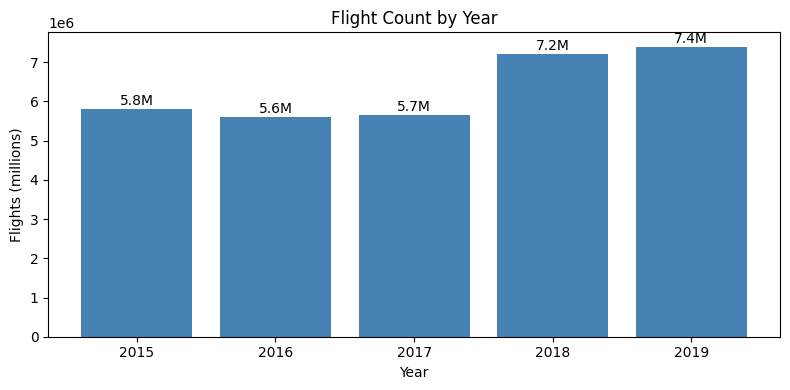

In [0]:
year_dist = (
    df_otpw_5y
    .withColumn("YEAR_EXTRACT", F.year(F.to_date("FL_DATE")))
    .groupBy("YEAR_EXTRACT")
    .agg(F.count("*").alias("flights"))
    .orderBy("YEAR_EXTRACT")
    .toPandas()
)
display(year_dist)

# Visualize
plt.figure(figsize=(8, 4))
plt.bar(year_dist["YEAR_EXTRACT"].astype(str), year_dist["flights"], color='steelblue')
plt.title("Flight Count by Year")
plt.ylabel("Flights (millions)")
plt.xlabel("Year")
for i, v in enumerate(year_dist["flights"]):
    plt.text(i, v + 100000, f'{v/1e6:.1f}M', ha='center', fontsize=10)
plt.tight_layout()
plt.show()

In [0]:
delay_stats = df_otpw_5y.select("DEP_DELAY").summary("count", "mean", "stddev", "min", "50%", "max").toPandas()
display(delay_stats)

null_count = df_otpw_5y.filter(F.col("DEP_DELAY").isNull()).count()
total_count = df_otpw_5y.count()
print(f"\nNull values: {null_count:,} ({100*null_count/total_count:.2f}%)")
print(f"Valid rows:  {total_count - null_count:,}")

summary,DEP_DELAY
count,31197330
mean,9.845084082516037
stddev,43.47592737302717
min,-1.0
50%,-2.0
max,999.0



Null values: 475,789 (1.50%)
Valid rows:  31,197,330


In [0]:
df = df_otpw_5y.filter(F.col("DEP_DELAY").isNotNull())

In [0]:
leakage_columns = [
    # Delay cause breakdowns (post-flight)
    "CARRIER_DELAY", "WEATHER_DELAY", "NAS_DELAY",
    "SECURITY_DELAY", "LATE_AIRCRAFT_DELAY",
    
    # Taxi and air time (post-departure)
    "TAXI_OUT", "TAXI_IN", "AIR_TIME",
    "WHEELS_OFF", "WHEELS_ON",
    
    # Arrival information (post-arrival)
    "ARR_DELAY", "ARR_DEL15", "ARR_TIME",
    "ACTUAL_ELAPSED_TIME",
    "ARR_DELAY_NEW", "ARR_DELAY_GROUP",
    "ARR_TIME_BLK",
    
    # Cancellation/Diversion details
    "CANCELLATION_CODE", "DIVERTED", "CANCELLED",
    
    # Departure information known only after departure
    "DEP_TIME", "DEP_DELAY_NEW", "DEP_DEL15",
    "DEP_DELAY_GROUP", "DEP_TIME_BLK",
    "TOTAL_ADD_GTIME", "LONGEST_ADD_GTIME"
]


In [0]:
daily_monthly_prefixes = ("Daily", "Monthly", "ShortDuration")

irrelevant_columns = [

    "origin_airport_name", "origin_station_name", "origin_station_id",
    "origin_iata_code", "origin_icao", "origin_type", "origin_region",
    "origin_airport_lat", "origin_airport_lon",
    "origin_station_lat", "origin_station_lon",
    "origin_station_dis",
    "dest_airport_name", "dest_station_name", "dest_station_id",
    "dest_iata_code", "dest_icao", "dest_type", "dest_region",
    "dest_airport_lat", "dest_airport_lon",
    "dest_station_lat", "dest_station_lon",
    "dest_station_dis",
    "ORIGIN_CITY_NAME", "ORIGIN_STATE_ABR", "ORIGIN_STATE_FIPS", "ORIGIN_STATE_NM",
    "DAY_OF_MONTH",
    "DEST_CITY_NAME",  "DEST_STATE_ABR",  "DEST_STATE_FIPS",  "DEST_STATE_NM",
    "ORIGIN_AIRPORT_ID", "ORIGIN_AIRPORT_SEQ_ID", "ORIGIN_CITY_MARKET_ID", "ORIGIN_WAC",
    "CRS_ARR_TIME", "OP_CARRIER",
    "DEST_AIRPORT_ID",   "DEST_AIRPORT_SEQ_ID",   "DEST_CITY_MARKET_ID",   "DEST_WAC",
    "STATION", "DATE", "LATITUDE", "LONGITUDE",
    "ELEVATION", "NAME", "REPORT_TYPE", "SOURCE",
    "AWND", "CDSD", "CLDD", "DSNW", "HDSD", "HTDD",
    "NormalsCoolingDegreeDay", "NormalsHeatingDegreeDay", "REM",
    "BackupDirection", "BackupDistance", "BackupDistanceUnit",
    "BackupElements", "BackupElevation", "BackupEquipment",
    "BackupLatitude", "BackupLongitude", "BackupName",
    "WindEquipmentChangeDate", "_row_desc",
    "TAIL_NUM",
    "OP_CARRIER_FL_NUM",
    "OP_CARRIER_AIRLINE_ID",
    "QUARTER",         
    "DISTANCE_GROUP",    
    "FLIGHTS",           
    "FIRST_DEP_TIME",  
    "sched_depart_date_time_UTC",  
    "four_hours_prior_depart_UTC",  
    "two_hours_prior_depart_UTC",   
    "Sunrise", 
    "Sunset",
    "HourlyAltimeterSetting",
    "HourlyPressureChange",
    "HourlyPressureTendency",
    "HourlySeaLevelPressure",
    "HourlyWindGustSpeed",
    "HourlyWindDirection",
    "HourlyWetBulbTemperature",
    "HourlyPrecipitation",
    "HourlyStationPressure",
    'HourlyPresentWeatherType',
    'HourlySkyConditions'
]


#### Dropping Leakage and Irrevelant Columns

In [0]:
drops = []

for c in df.columns:
    if c.startswith(daily_monthly_prefixes):
        drops.append(c)
    elif c in leakage_columns:
        drops.append(c)
    elif c in irrelevant_columns:
        drops.append(c)

df = df.drop(*set(drops))


In [0]:
row_count = df_otpw_5y.count()
cleaned_row_count = df.count()
col_count = len(df_otpw_5y.columns)
cleaned_col_count = len(df.columns)

rows_removed = row_count - cleaned_row_count
cols_removed = col_count - cleaned_col_count

summary_data = {
    "Metric": ["Rows", "Columns"],
    "Before Cleaning": [f"{row_count:,}", col_count],
    "After Cleaning": [f"{cleaned_row_count:,}", cleaned_col_count],
    "Removed": [f"{rows_removed:,}", cols_removed],
}

summary_df = pd.DataFrame(summary_data)
display(summary_df)

/databricks/spark/python/pyspark/sql/pandas/conversion.py:516: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Expected bytes, got a 'int' object
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


Metric,Before Cleaning,After Cleaning,Removed
Rows,"31,673,119","31,197,330","475,789"
Columns,214,16,198


In [0]:
df.columns

['DAY_OF_WEEK',
 'FL_DATE',
 'OP_UNIQUE_CARRIER',
 'ORIGIN',
 'DEST',
 'CRS_DEP_TIME',
 'DEP_DELAY',
 'CRS_ELAPSED_TIME',
 'DISTANCE',
 'YEAR',
 'MONTH',
 'HourlyDewPointTemperature',
 'HourlyDryBulbTemperature',
 'HourlyRelativeHumidity',
 'HourlyVisibility',
 'HourlyWindSpeed']

#### Type Casting
Convert columns into appropriate data types, raw data often has numeric values stored as strings. 

In [0]:
# Integer columns
int_cols = [
    "YEAR",
    "MONTH",
    "DAY_OF_WEEK",
    "CRS_DEP_TIME"
]

# Numeric weather columns
weather_numeric = [
    "HourlyDewPointTemperature",
    "HourlyDryBulbTemperature",
    "HourlyRelativeHumidity",
    "HourlyVisibility",
    "HourlyWindSpeed",
]

# Flight numeric columns (non-leakage)
flight_numeric = [
    "DEP_DELAY",
    "CRS_ELAPSED_TIME",
    "DISTANCE"
]

# Combine all numeric columns to cast as double
double_cols = weather_numeric + flight_numeric

# CAST INT COLUMNS 
for c in int_cols:
    if c in df.columns:
        df = df.withColumn(c, F.col(c).cast("int"))

# CAST DOUBLE COLUMNS
for c in double_cols:
    if c in df.columns:
        df = df.withColumn(c, F.col(c).cast("double"))

print("Casting complete.")
print("Int columns cast:", int_cols)
print("Double columns cast:", double_cols)


Casting complete.
Int columns cast: ['YEAR', 'MONTH', 'DAY_OF_WEEK', 'CRS_DEP_TIME']
Double columns cast: ['HourlyDewPointTemperature', 'HourlyDryBulbTemperature', 'HourlyRelativeHumidity', 'HourlyVisibility', 'HourlyWindSpeed', 'DEP_DELAY', 'CRS_ELAPSED_TIME', 'DISTANCE']


#### Categorical Cleaning 
Standardize categorical columns by trimming whitespace, converting to uppercase, and handling empty strings.

In [0]:
cat_cols = [
    "OP_UNIQUE_CARRIER",
    "ORIGIN",
    "DEST"
]

# Clean categorical columns
for c in cat_cols:
    df = df.withColumn(
        c,
        F.upper(
            F.when(F.length(F.trim(F.col(c))) == 0, None)
             .otherwise(F.trim(F.col(c)))
        )
    )

print("\nUnique values AFTER cleaning:")
for c in cat_cols:
    unique_count = df.select(c).distinct().count()
    print(f"  {c:25} {unique_count:>6} unique values")

print("\nNull counts AFTER cleaning:")
null_counts = (
    df.select([F.sum(F.col(c).isNull().cast("int")).alias(c) for c in cat_cols])
      .collect()[0]
      .asDict()
)

for c in cat_cols:
    print(f"{c:25} {null_counts[c]:>10,} nulls")




Unique values AFTER cleaning:
  OP_UNIQUE_CARRIER             19 unique values
  ORIGIN                       369 unique values
  DEST                         368 unique values

Null counts AFTER cleaning:
OP_UNIQUE_CARRIER                  0 nulls
ORIGIN                             0 nulls
DEST                               0 nulls


#### Temporal EDA

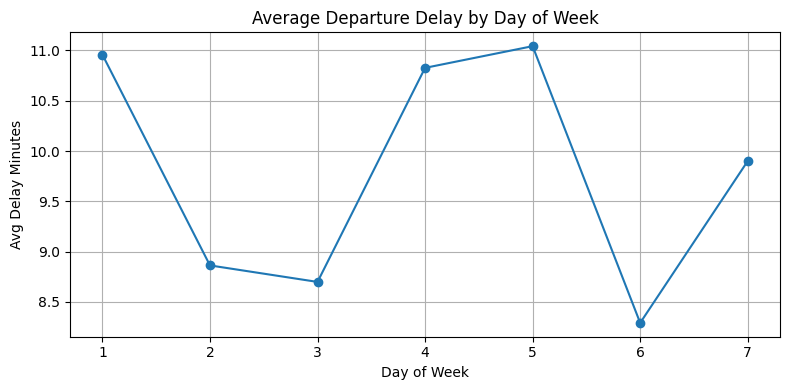

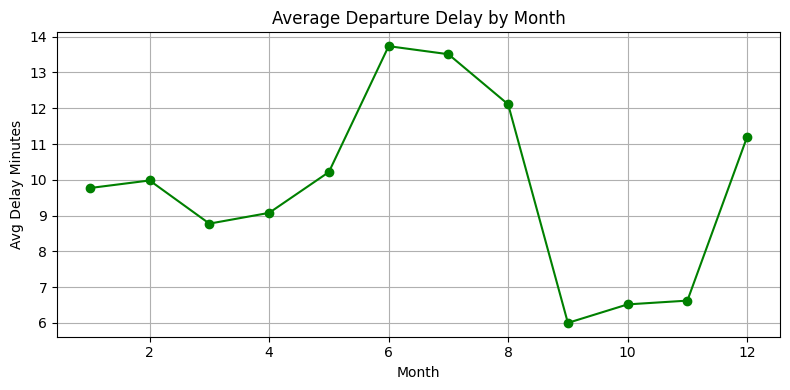

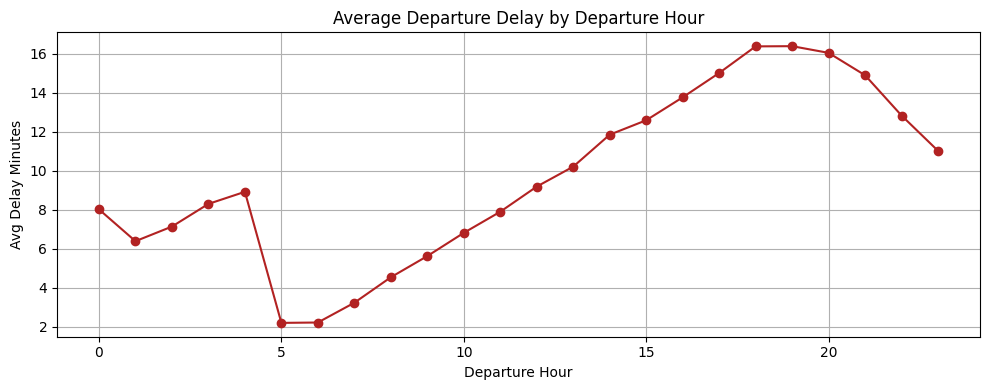

In [0]:
# Extract hour from CRS_DEP_TIME
df = df.withColumn("DEP_HOUR", (F.col("CRS_DEP_TIME") / 100).cast("int"))

# Average delay by day of week
dow_delay = (
    df.groupBy("DAY_OF_WEEK")
      .agg(F.avg("DEP_DELAY").alias("avg_delay"))
      .orderBy("DAY_OF_WEEK")
      .toPandas()
)

# Average delay by month
month_delay = (
    df.groupBy("MONTH")
      .agg(F.avg("DEP_DELAY").alias("avg_delay"))
      .orderBy("MONTH")
      .toPandas()
)

# Average delay by departure hour
hour_delay = (
    df.groupBy("DEP_HOUR")
      .agg(F.avg("DEP_DELAY").alias("avg_delay"))
      .orderBy("DEP_HOUR")
      .toPandas()
)


# Plot average delay by day of week
plt.figure(figsize=(8, 4))
plt.plot(dow_delay["DAY_OF_WEEK"], dow_delay["avg_delay"], marker="o")
plt.title("Average Departure Delay by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Avg Delay Minutes")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot average delay by month
plt.figure(figsize=(8, 4))
plt.plot(month_delay["MONTH"], month_delay["avg_delay"], marker="o", color="green")
plt.title("Average Departure Delay by Month")
plt.xlabel("Month")
plt.ylabel("Avg Delay Minutes")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot average delay by departure hour
plt.figure(figsize=(10, 4))
plt.plot(hour_delay["DEP_HOUR"], hour_delay["avg_delay"], marker="o", color="firebrick")
plt.title("Average Departure Delay by Departure Hour")
plt.xlabel("Departure Hour")
plt.ylabel("Avg Delay Minutes")
plt.grid(True)
plt.tight_layout()
plt.show()


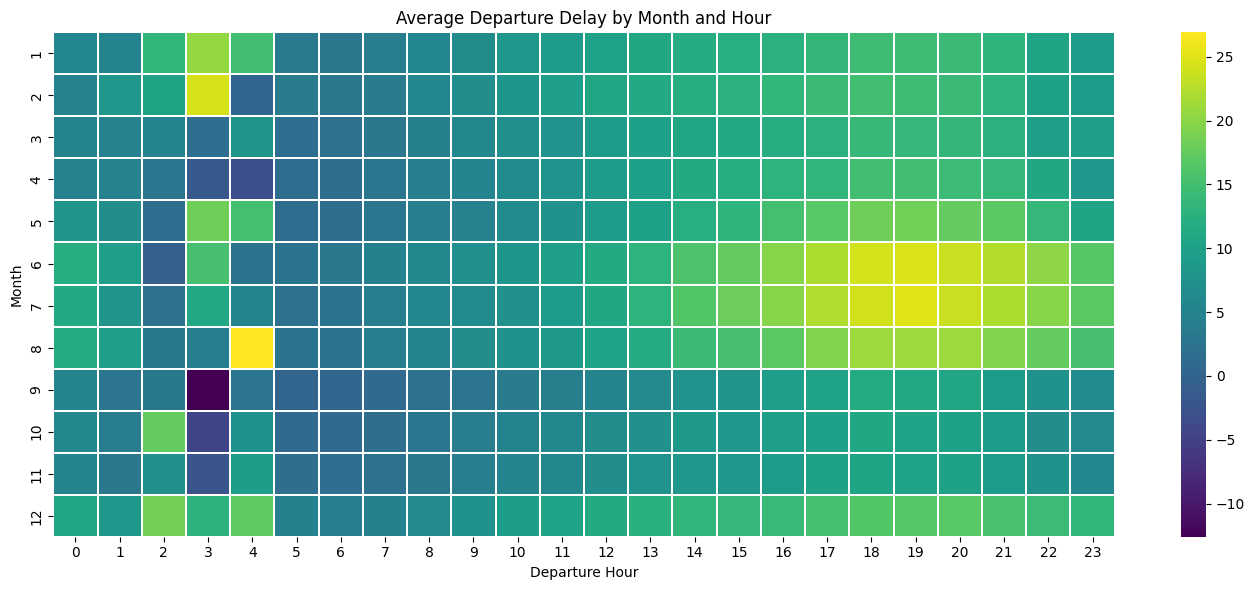

In [0]:
# Compute month x hour average delay
month_hour_delay = (
    df.groupBy("MONTH", "DEP_HOUR")
      .agg(F.avg("DEP_DELAY").alias("avg_delay"))
      .orderBy("MONTH", "DEP_HOUR")
      .toPandas()
)

# Pivot for heatmap
heatmap_data = month_hour_delay.pivot(index="MONTH", columns="DEP_HOUR", values="avg_delay")

plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_data, cmap="viridis", linewidths=0.3)
plt.title("Average Departure Delay by Month and Hour")
plt.xlabel("Departure Hour")
plt.ylabel("Month")
plt.tight_layout()
plt.show()

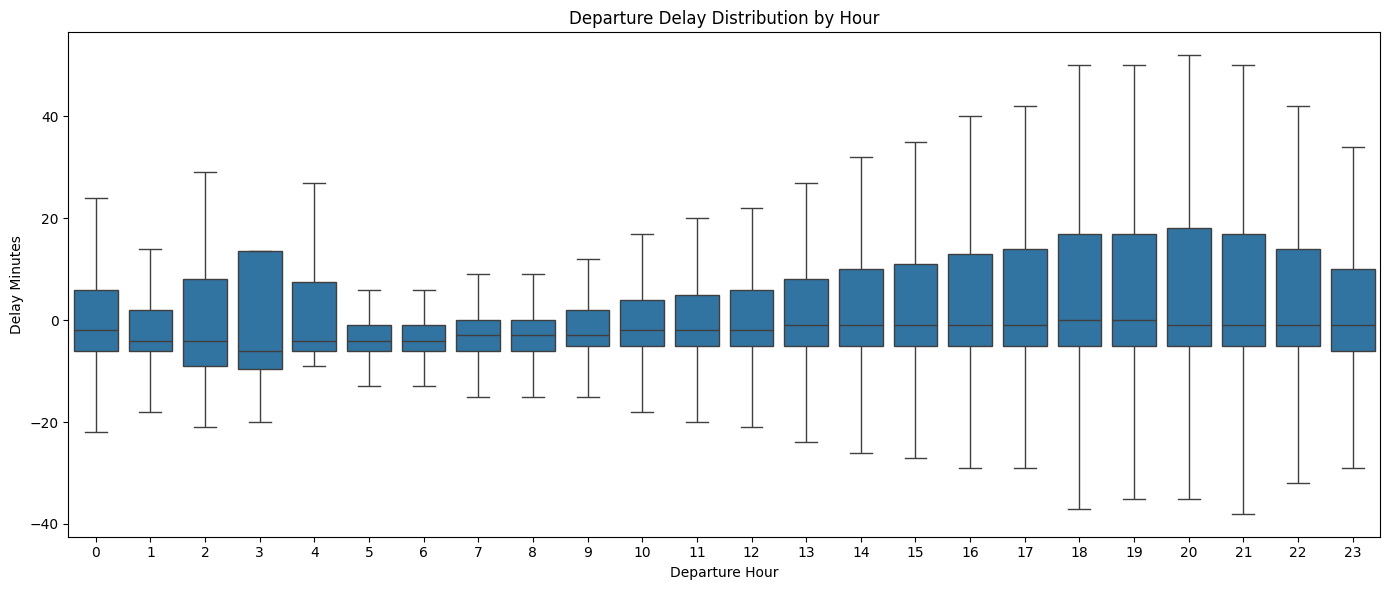

In [0]:
# Sample for boxplot speed
sample_pdf = (
    df.select("DEP_HOUR", "DEP_DELAY")
      .sample(0.02, seed=42)
      .toPandas()
)

plt.figure(figsize=(14, 6))
sns.boxplot(x="DEP_HOUR", y="DEP_DELAY", data=sample_pdf, showfliers=False)
plt.title("Departure Delay Distribution by Hour")
plt.xlabel("Departure Hour")
plt.ylabel("Delay Minutes")
plt.tight_layout()
plt.show()


/root/.ipykernel/10446/command-8173636742503533-2853196169:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="MONTH", y="DEP_DELAY", data=sample_pdf, showfliers=False, palette="coolwarm")


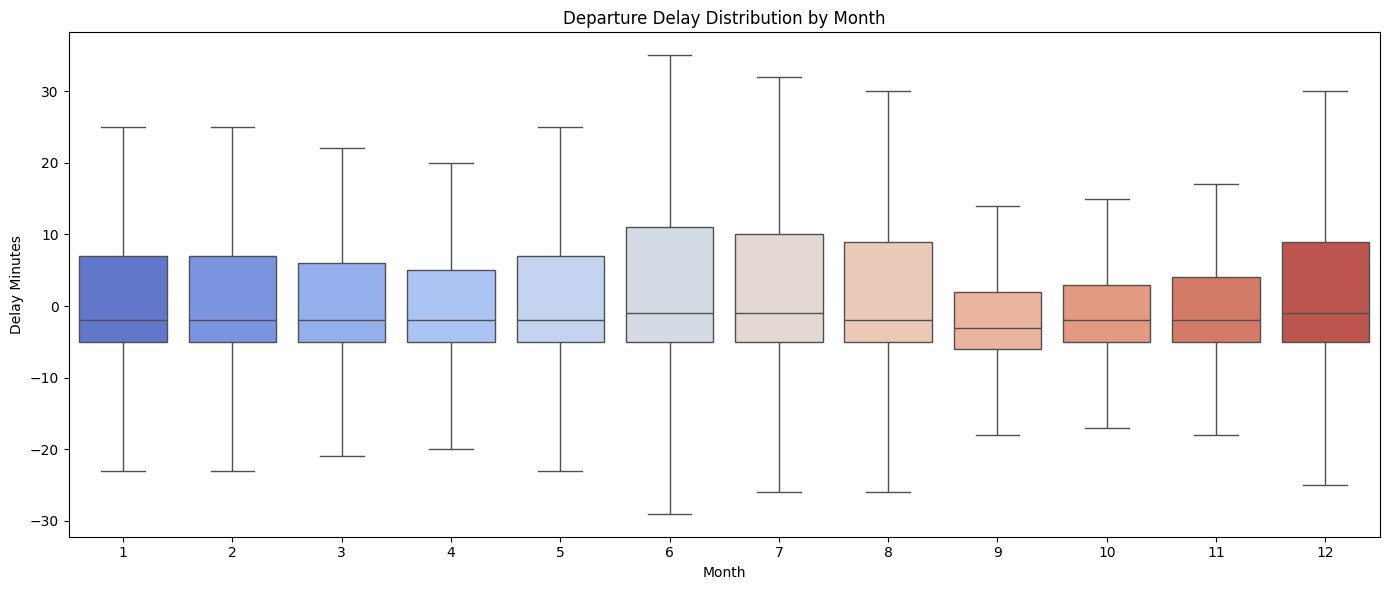

In [0]:
# Sample for boxplot speed
sample_pdf = (
    df.select("MONTH", "DEP_DELAY")
      .sample(0.02, seed=42)
      .toPandas()
)

plt.figure(figsize=(14, 6))
sns.boxplot(x="MONTH", y="DEP_DELAY", data=sample_pdf, showfliers=False, palette="coolwarm")
plt.title("Departure Delay Distribution by Month")
plt.xlabel("Month")
plt.ylabel("Delay Minutes")
plt.tight_layout()
plt.show()


#### Carrier EDA

OP_UNIQUE_CARRIER,flights,avg_delay,median_delay
WN,6497693,10.248872330533313,0.0
DL,4636603,7.895255858653415,-2.0
AA,4328413,9.683932425117474,-2.0
OO,3453002,9.890727546639127,-4.0
UA,2856368,11.606514986864438,-2.0
EV,1691580,10.807558022677023,-4.0
B6,1400194,14.992995256371618,-2.0
AS,1036229,2.6457115174348527,-4.0
MQ,881643,9.048738548369352,-3.0
NK,775224,11.528444681795197,-3.0


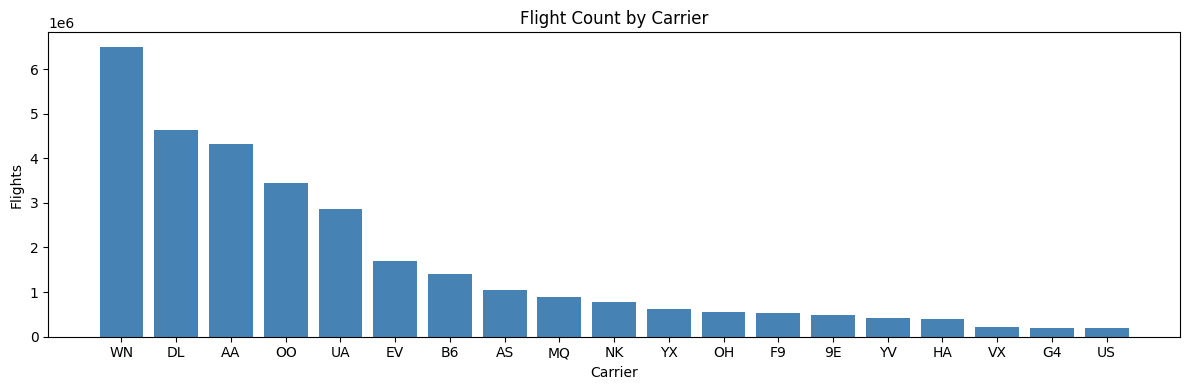

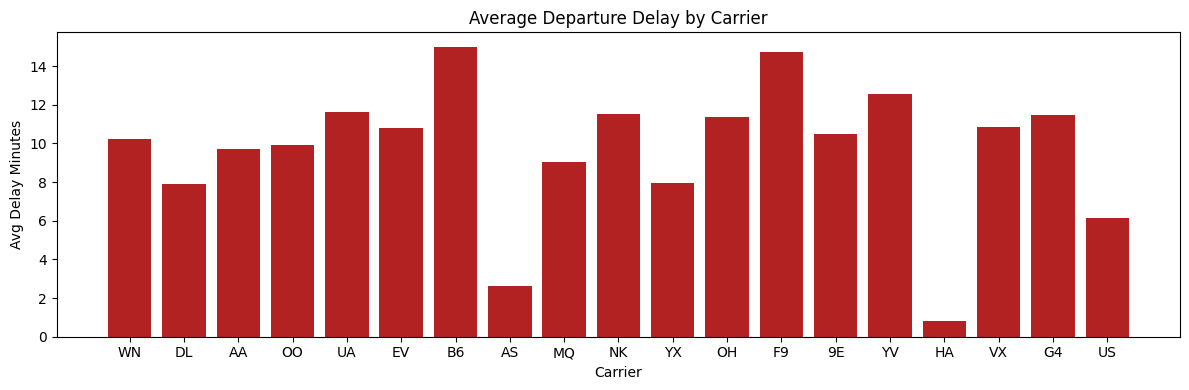

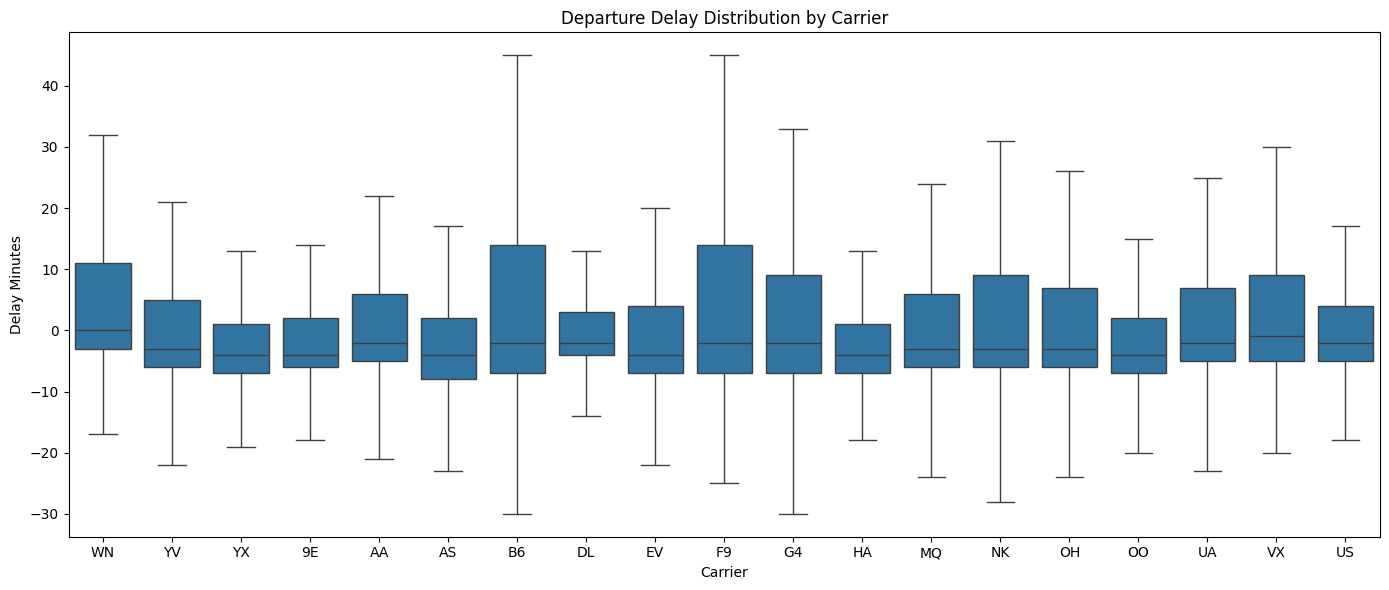

In [0]:
# Average delay by carrier
carrier_delay = (
    df.groupBy("OP_UNIQUE_CARRIER")
      .agg(
          F.count("*").alias("flights"),
          F.avg("DEP_DELAY").alias("avg_delay"),
          F.percentile_approx("DEP_DELAY", 0.5).alias("median_delay")
      )
      .orderBy(F.desc("flights"))
      .toPandas()
)

display(carrier_delay)

plt.figure(figsize=(12, 4))
plt.bar(carrier_delay["OP_UNIQUE_CARRIER"], carrier_delay["flights"], color="steelblue")
plt.title("Flight Count by Carrier")
plt.xlabel("Carrier")
plt.ylabel("Flights")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
plt.bar(carrier_delay["OP_UNIQUE_CARRIER"], carrier_delay["avg_delay"], color="firebrick")
plt.title("Average Departure Delay by Carrier")
plt.xlabel("Carrier")
plt.ylabel("Avg Delay Minutes")
plt.tight_layout()
plt.show()

sample_pdf = (
    df.select("OP_UNIQUE_CARRIER", "DEP_DELAY")
      .sample(0.02, seed=42)
      .toPandas()
)

plt.figure(figsize=(14, 6))
sns.boxplot(
    x="OP_UNIQUE_CARRIER",
    y="DEP_DELAY",
    data=sample_pdf,
    showfliers=False
)
plt.title("Departure Delay Distribution by Carrier")
plt.xlabel("Carrier")
plt.ylabel("Delay Minutes")
plt.tight_layout()
plt.show()


#### Route EDA

ORIGIN,DEST,flights,ROUTE
SFO,LAX,76083,SFO-LAX
LAX,SFO,75154,LAX-SFO
LAX,JFK,63478,LAX-JFK
JFK,LAX,63466,JFK-LAX
LGA,ORD,58915,LGA-ORD
ORD,LGA,58736,ORD-LGA
LAS,LAX,56394,LAS-LAX
LAX,LAS,56308,LAX-LAS
OGG,HNL,48580,OGG-HNL
HNL,OGG,48531,HNL-OGG


ORIGIN,DEST,avg_delay,ROUTE
ICT,MHK,1484.0,ICT-MHK
TVC,MQT,1480.0,TVC-MQT
PIH,MSO,1475.0,PIH-MSO
TVC,IMT,1470.0,TVC-IMT
CAK,TYS,1236.0,CAK-TYS
ESC,MQT,1048.0,ESC-MQT
RDM,MFR,814.0,RDM-MFR
PSP,BUR,800.0,PSP-BUR
MDT,HPN,759.0,MDT-HPN
BDL,PVD,758.0,BDL-PVD


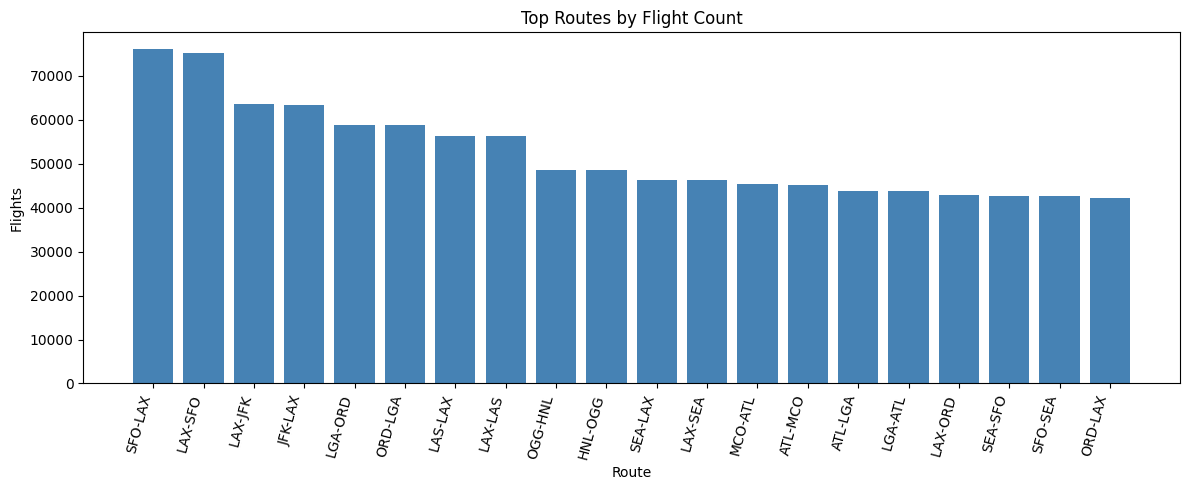

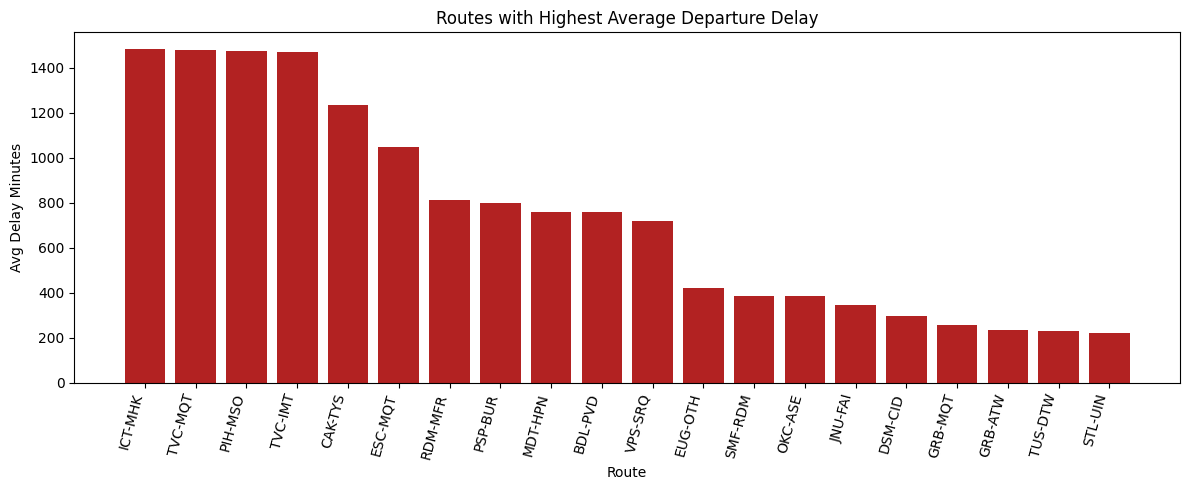

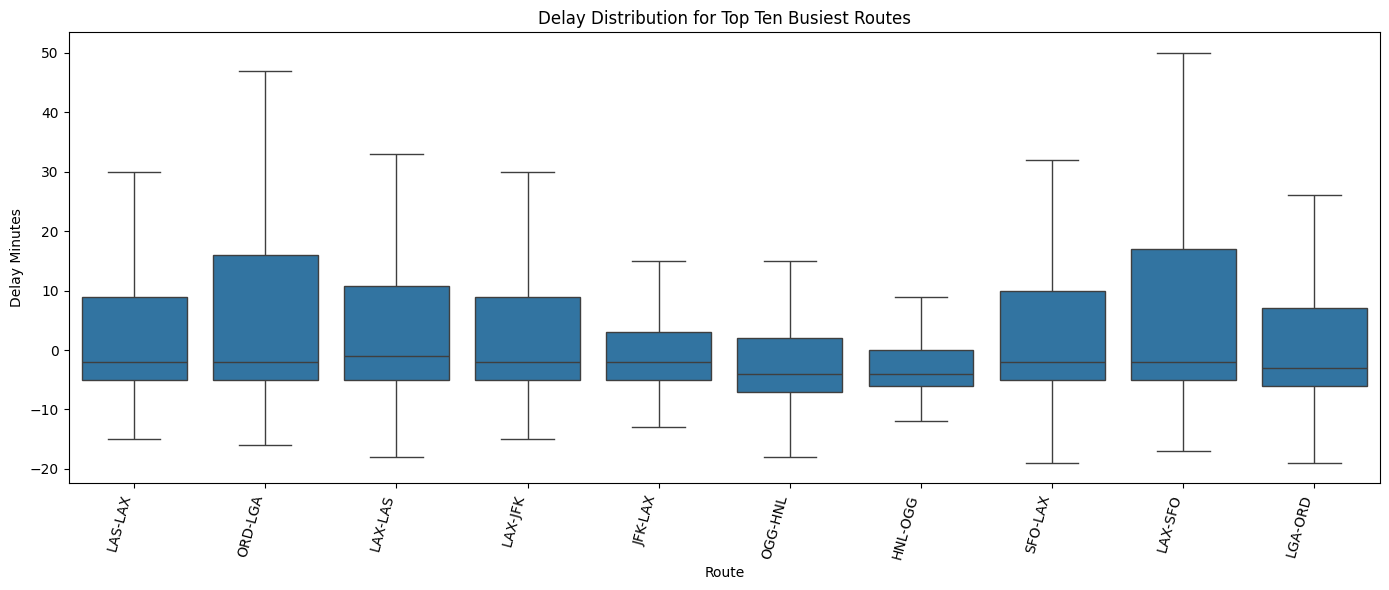

In [0]:
route_counts = (
    df.groupBy("ORIGIN", "DEST")
      .agg(F.count("*").alias("flights"))
      .orderBy(F.desc("flights"))
      .limit(20)
      .toPandas()
)

route_counts["ROUTE"] = route_counts["ORIGIN"] + "-" + route_counts["DEST"]
display(route_counts)

route_delay = (
    df.groupBy("ORIGIN", "DEST")
      .agg(F.avg("DEP_DELAY").alias("avg_delay"))
      .orderBy(F.desc("avg_delay"))
      .limit(20)
      .toPandas()
)

route_delay["ROUTE"] = route_delay["ORIGIN"] + "-" + route_delay["DEST"]
display(route_delay)

plt.figure(figsize=(12, 5))
plt.bar(route_counts["ROUTE"], route_counts["flights"], color="steelblue")
plt.xticks(rotation=75, ha="right")
plt.title("Top Routes by Flight Count")
plt.xlabel("Route")
plt.ylabel("Flights")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
plt.bar(route_delay["ROUTE"], route_delay["avg_delay"], color="firebrick")
plt.xticks(rotation=75, ha="right")
plt.title("Routes with Highest Average Departure Delay")
plt.xlabel("Route")
plt.ylabel("Avg Delay Minutes")
plt.tight_layout()
plt.show()

top10_routes = (
    route_counts["ROUTE"]
    .head(10)
    .tolist()
)

sample_pdf = (
    df.withColumn("ROUTE", F.concat_ws("-", "ORIGIN", "DEST"))
      .filter(F.col("ROUTE").isin(top10_routes))
      .select("ROUTE", "DEP_DELAY")
      .sample(0.02, seed=42)
      .toPandas()
)

plt.figure(figsize=(14, 6))
sns.boxplot(x="ROUTE", y="DEP_DELAY", data=sample_pdf, showfliers=False)
plt.xticks(rotation=75, ha="right")
plt.title("Delay Distribution for Top Ten Busiest Routes")
plt.xlabel("Route")
plt.ylabel("Delay Minutes")
plt.tight_layout()
plt.show()




#### Weather Imputation

In [0]:
weather_cols = [
    'HourlyDewPointTemperature',
    'HourlyDryBulbTemperature',
    'HourlyRelativeHumidity',
    'HourlyVisibility',
    'HourlyWindSpeed']

missing_df = df.select([
    F.sum(F.col(c).isNull().cast("int")).alias(c)
    for c in weather_cols
])
total_rows = df.count()
missing_counts = missing_df.collect()[0].asDict()

print("Weather Missingness BEFORE Imputation (%)")
for c in weather_cols:
    nulls = missing_counts[c]
    print(f"{c:35} {nulls:>10,} nulls ({100*nulls/total_rows:.2f}%)")


Weather Missingness BEFORE Imputation (%)
HourlyDewPointTemperature               93,579 nulls (0.30%)
HourlyDryBulbTemperature                82,466 nulls (0.26%)
HourlyRelativeHumidity                  81,728 nulls (0.26%)
HourlyVisibility                        94,998 nulls (0.30%)
HourlyWindSpeed                         88,687 nulls (0.28%)


In [0]:
# compute medians without leaking across years
monthly_medians = df.groupBy("ORIGIN", "YEAR", "MONTH").agg(
    *[F.percentile_approx(c, 0.5).alias(f"{c}_month_med") for c in weather_cols]
)

yearly_medians = df.groupBy("ORIGIN", "YEAR").agg(
    *[F.percentile_approx(c, 0.5).alias(f"{c}_year_med") for c in weather_cols]
)

global_medians = df.agg(
    *[F.percentile_approx(c, 0.5).alias(f"{c}_global_med") for c in weather_cols]
).collect()[0].asDict()

# join medians
df = df.join(monthly_medians, ["ORIGIN", "YEAR", "MONTH"], "left")
df = df.join(yearly_medians, ["ORIGIN", "YEAR"], "left")

# impute
for c in weather_cols:
    df = df.withColumn(
        c,
        F.coalesce(
            F.col(c),
            F.col(f"{c}_month_med"),
            F.col(f"{c}_year_med"),
            F.lit(global_medians[f"{c}_global_med"])
        )
    )

# clean up
drop_cols = []
for c in weather_cols:
    drop_cols += [f"{c}_month_med", f"{c}_year_med"]

df = df.drop(*drop_cols)


In [0]:
print("\nWeather Missingness AFTER Imputation:")

missing_after = df.select([
    F.sum(F.col(c).isNull().cast("int")).alias(c)
    for c in weather_cols
]).collect()[0].asDict()

for c in weather_cols:
    print(f"{c:35} {missing_after[c]:>10,} nulls")



Weather Missingness AFTER Imputation:
HourlyDewPointTemperature                    0 nulls
HourlyDryBulbTemperature                     0 nulls
HourlyRelativeHumidity                       0 nulls
HourlyVisibility                             0 nulls
HourlyWindSpeed                              0 nulls


#### Weather EDA

summary,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyRelativeHumidity,HourlyVisibility,HourlyWindSpeed
count,31197330,31197330,31197330,31197330,31197330
mean,47.60117388250853,63.97712762598594,60.413298830380675,9.447712374743999,9.055874845699936
stddev,18.538821085727623,18.695777619163426,21.63436005739295,1.8254442376539404,5.634617912298348
min,-47.0,-51.0,1.0,0.0,0.0
50%,50.0,66.0,62.0,10.0,8.0
max,95.0,125.0,100.0,99.42,2237.0


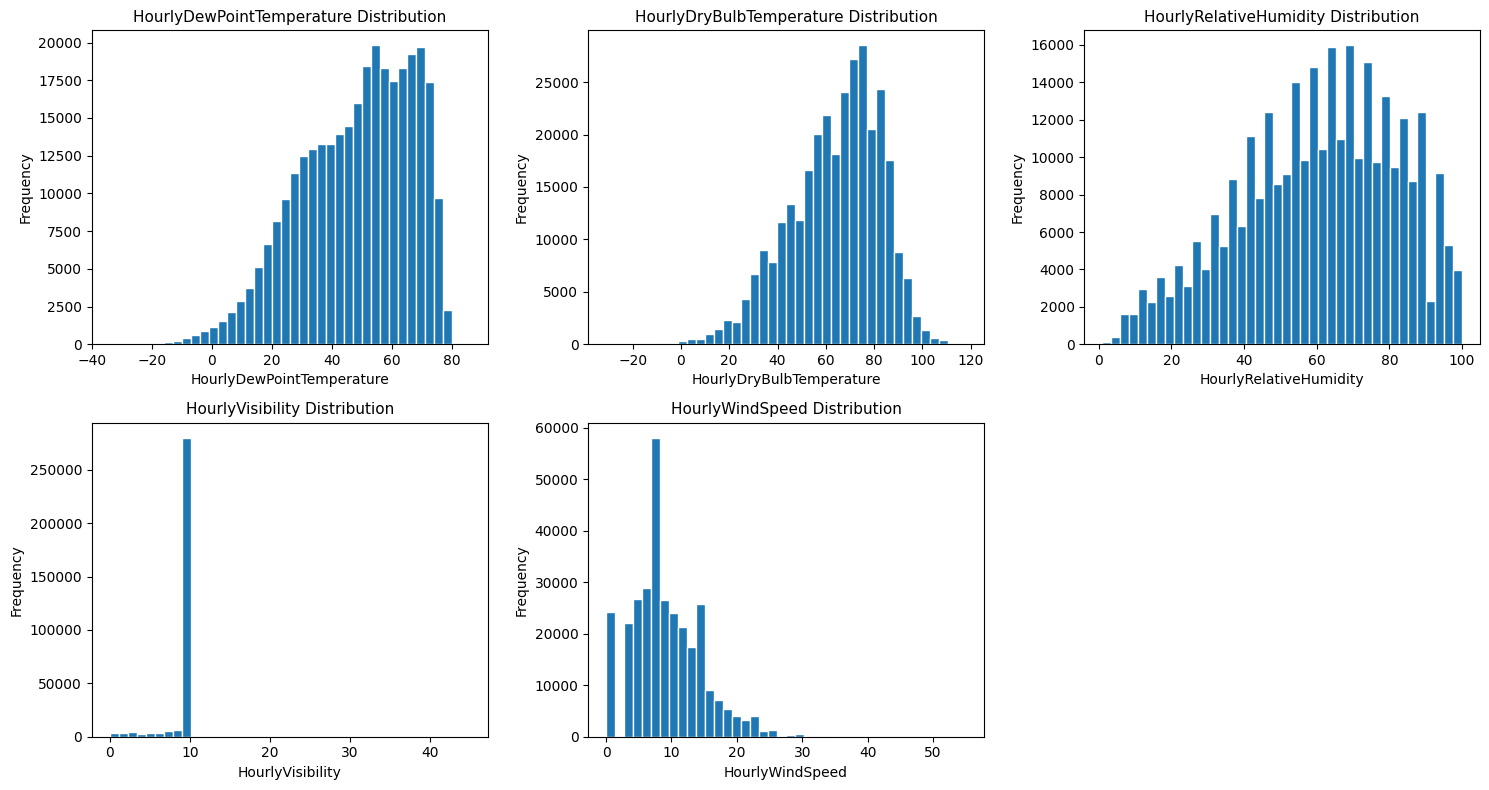

In [0]:
# Summary statistics
weather_stats = (
    df.select(weather_cols)
      .summary("count", "mean", "stddev", "min", "50%", "max")
      .toPandas()
)

display(weather_stats)

rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 8))
axes = axes.flatten()

for i, c in enumerate(weather_cols):
    # Sample 1% of the column for plotting
    sample_pdf = (
        df.select(c)
          .sample(0.01, seed=42)
          .toPandas()
    )

    axes[i].hist(sample_pdf[c].dropna(), bins=40, edgecolor='white')
    axes[i].set_title(f"{c} Distribution", fontsize=11)
    axes[i].set_xlabel(c)
    axes[i].set_ylabel("Frequency")

fig.delaxes(axes[5])
plt.tight_layout()
plt.show()


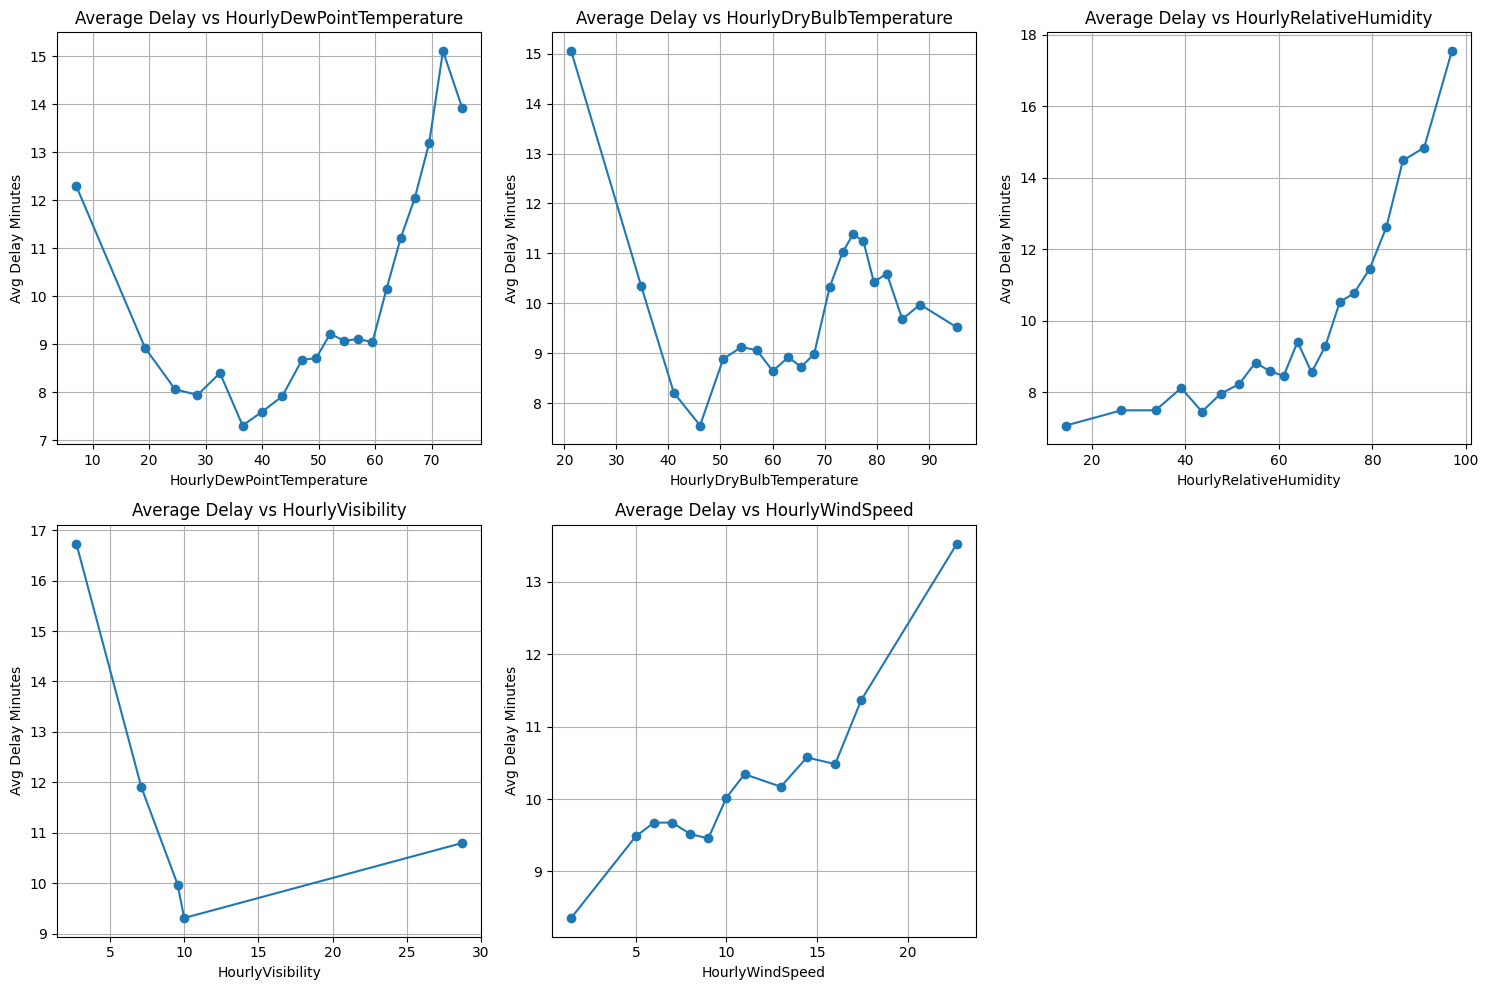

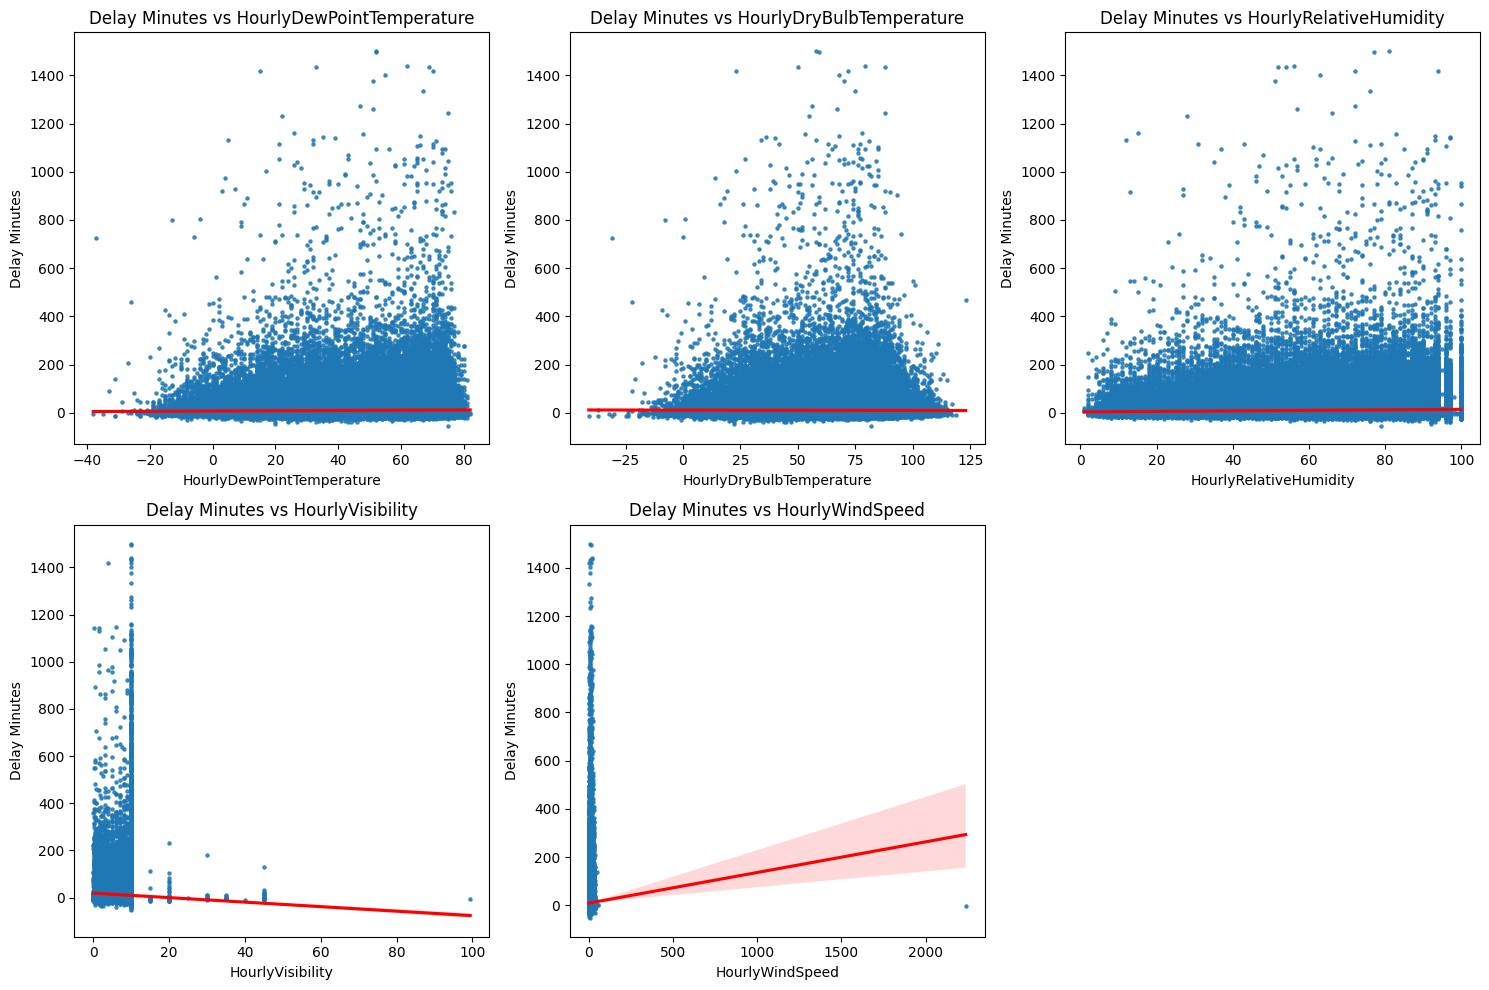

In [0]:
sample_pdf = (
    df.select(weather_cols + ["DEP_DELAY"])
      .sample(0.01, seed=42)
      .toPandas()
)

weather_bins = {}

for c in weather_cols:
    sample_pdf[c + "_bin"] = pd.qcut(sample_pdf[c], q=20, duplicates="drop")
    weather_bins[c] = (
        sample_pdf.groupby(c + "_bin")
                  .agg(
                      value=(c, "mean"),
                      avg_delay=("DEP_DELAY", "mean")
                  )
                  .reset_index()
    )

plt.figure(figsize=(15, 10))

for i, c in enumerate(weather_cols):
    plt.subplot(2, 3, i + 1)
    plt.plot(weather_bins[c]["value"], weather_bins[c]["avg_delay"], marker="o")
    plt.title("Average Delay vs " + c)
    plt.xlabel(c)
    plt.ylabel("Avg Delay Minutes")
    plt.grid(True)

plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 10))

for i, c in enumerate(weather_cols):
    plt.subplot(2, 3, i + 1)
    sns.regplot(
        x=c,
        y="DEP_DELAY",
        data=sample_pdf,
        scatter_kws={"s": 5},
        line_kws={"color": "red"}
    )
    plt.title("Delay Minutes vs " + c)
    plt.xlabel(c)
    plt.ylabel("Delay Minutes")

plt.tight_layout()
plt.show()


### Feature Engineering & EDA

Temporal

In [0]:
# Ensure timestamp exists
df = df.withColumn("FL_DATE_TS", F.to_timestamp("FL_DATE"))

# Create padded departure time
df = df.withColumn("CRS_DEP_TIME_PAD", F.lpad(F.col("CRS_DEP_TIME"), 4, "0"))
df = df.withColumn("CRS_DEP_TIME_INT", F.col("CRS_DEP_TIME_PAD").cast("int"))
df = df.drop("CRS_DEP_TIME_PAD")

# Hour of day
df = df.withColumn("HOUR_OF_DAY", F.floor(F.col("CRS_DEP_TIME_INT") / 100))

# Season bucket
df = df.withColumn(
    "SEASON",
    F.when(F.col("MONTH").isin([12, 1, 2]), "winter")
     .when(F.col("MONTH").isin([3, 4, 5]), "spring")
     .when(F.col("MONTH").isin([6, 7, 8]), "summer")
     .otherwise("fall")
)

# Peak hour indicator
df = df.withColumn(
    "IS_PEAK_HOUR",
    F.when(F.col("HOUR_OF_DAY").isin([15, 16, 17, 18, 19, 20]), 1).otherwise(0)
)

# Early morning indicator
df = df.withColumn(
    "IS_EARLY_MORNING",
    F.when(F.col("HOUR_OF_DAY") < 6, 1).otherwise(0)
)


In [0]:
# Build federal holidays for all years in dataset
years = (
    df.select(F.year("FL_DATE_TS").alias("yr"))
      .distinct()
      .orderBy("yr")
      .toPandas()["yr"]
      .tolist()
)

def us_holidays(year):
    return [
        ("NewYearsDay",      pd.Timestamp(year, 1, 1)),
        ("MLKDay",           pd.Timestamp(year, 1, 1) + pd.offsets.Week(weekday=0) + pd.offsets.Week(2)),
        ("PresidentsDay",    pd.Timestamp(year, 2, 1) + pd.offsets.Week(weekday=0) + pd.offsets.Week(2)),
        ("MemorialDay",      pd.Timestamp(year, 5, 31) - pd.offsets.Week(weekday=0)),
        ("IndependenceDay",  pd.Timestamp(year, 7, 4)),
        ("LaborDay",         pd.Timestamp(year, 9, 1) + pd.offsets.Week(weekday=0)),
        ("ColumbusDay",      pd.Timestamp(year, 10, 1) + pd.offsets.Week(weekday=0) + pd.offsets.Week(1)),
        ("VeteransDay",      pd.Timestamp(year, 11, 11)),
        ("Thanksgiving",     pd.Timestamp(year, 11, 1) + pd.offsets.Week(weekday=3) + pd.offsets.Week(3)),
        ("Christmas",        pd.Timestamp(year, 12, 25)),
    ]

holiday_rows = []
for yr in years:
    for name, d in us_holidays(yr):
        holiday_rows.append(Row(HOLIDAY_NAME=name, HOLIDAY_DATE=str(d.date())))

holiday_df = (
    spark.createDataFrame(holiday_rows)
         .withColumn("HOLIDAY_DATE", F.to_date("HOLIDAY_DATE"))
)

# Holiday exact match flag
df = (
    df.alias("fl")
      .join(
          holiday_df.alias("h1"),
          F.col("fl.FL_DATE_TS") == F.col("h1.HOLIDAY_DATE"),
          "left"
      )
      .withColumn("IS_HOLIDAY", F.when(F.col("h1.HOLIDAY_NAME").isNotNull(), 1).otherwise(0))
      .drop("HOLIDAY_NAME", "HOLIDAY_DATE")
)

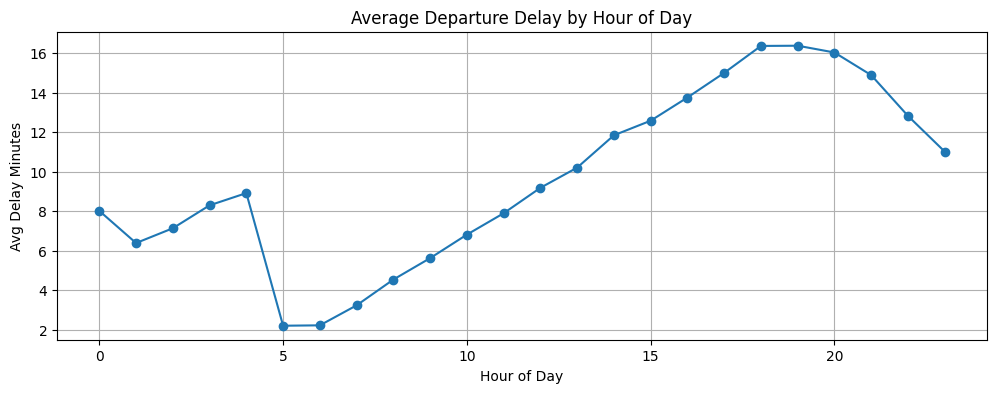

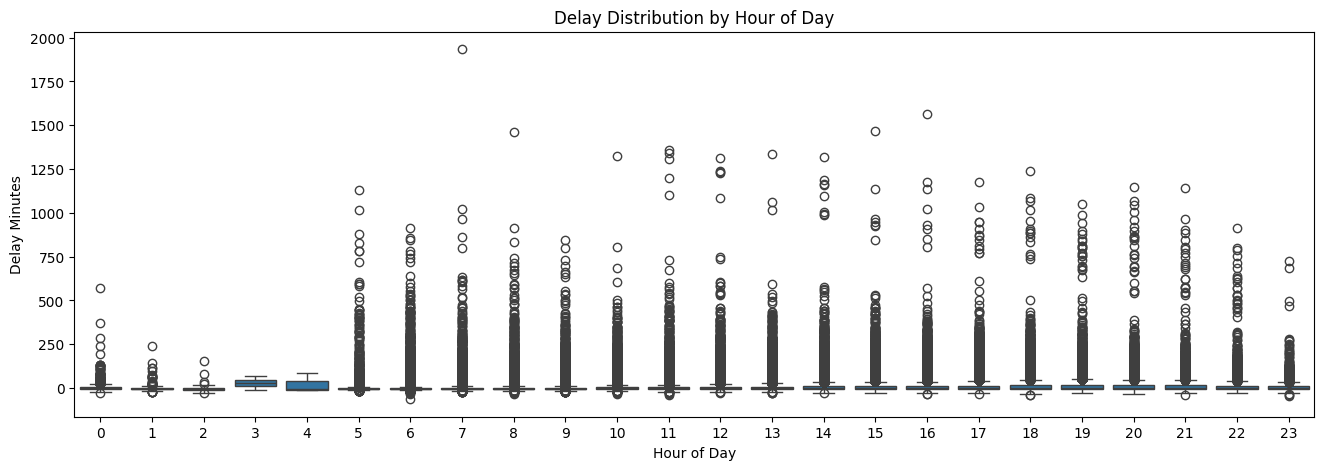

In [0]:
hour_eda = (
    df.groupBy("HOUR_OF_DAY")
      .agg(F.avg("DEP_DELAY").alias("avg_delay"),
           F.count("*").alias("flights"))
      .orderBy("HOUR_OF_DAY")
      .toPandas()
)

plt.figure(figsize=(12, 4))
plt.plot(hour_eda["HOUR_OF_DAY"], hour_eda["avg_delay"], marker="o")
plt.title("Average Departure Delay by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Avg Delay Minutes")
plt.grid(True)
plt.show()

plt.figure(figsize=(16, 5))
sample_pdf = df.select("HOUR_OF_DAY", "DEP_DELAY").sample(0.01, seed=42).toPandas()
sns.boxplot(data=sample_pdf, x="HOUR_OF_DAY", y="DEP_DELAY")
plt.title("Delay Distribution by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Delay Minutes")
plt.show()


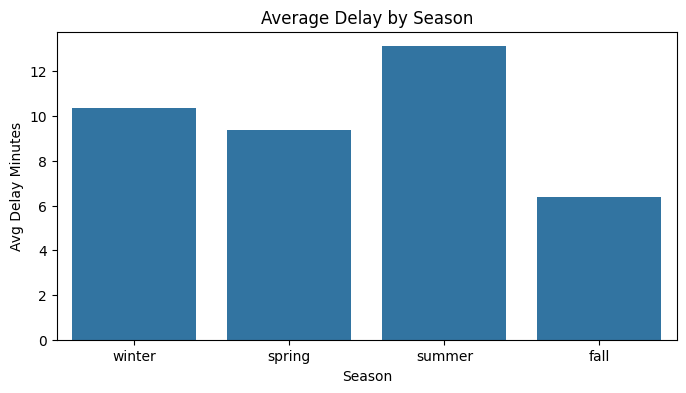

In [0]:
season_eda = (
    df.groupBy("SEASON")
      .agg(F.avg("DEP_DELAY").alias("avg_delay"))
      .toPandas()
)

season_order = ["winter", "spring", "summer", "fall"]
season_eda["SEASON"] = pd.Categorical(season_eda["SEASON"], season_order)
season_eda = season_eda.sort_values("SEASON")

plt.figure(figsize=(8, 4))
sns.barplot(data=season_eda, x="SEASON", y="avg_delay")
plt.title("Average Delay by Season")
plt.xlabel("Season")
plt.ylabel("Avg Delay Minutes")
plt.show()


In [0]:
holiday_eda = (
    df.groupBy("IS_HOLIDAY")
      .agg(F.avg("DEP_DELAY").alias("avg_delay"))
      .orderBy("IS_HOLIDAY")
      .toPandas()
)

display(holiday_eda)


IS_HOLIDAY,avg_delay
0,9.875900665348116
1,8.670093214131624


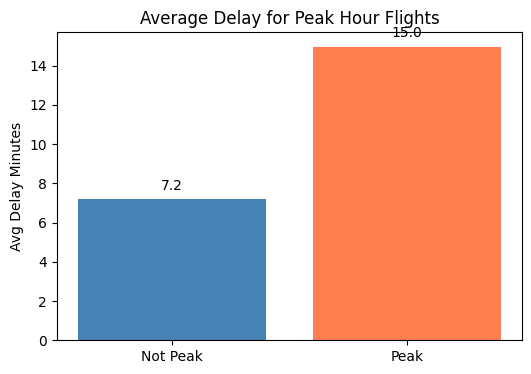

In [0]:
peak_eda = (
    df.groupBy("IS_PEAK_HOUR")
      .agg(F.avg("DEP_DELAY").alias("avg_delay"))
      .orderBy("IS_PEAK_HOUR")
      .toPandas()
)

labels = ["Not Peak", "Peak"]
values = peak_eda["avg_delay"].tolist()

plt.figure(figsize=(6, 4))
bars = plt.bar(labels, values, color=["steelblue", "coral"])
plt.title("Average Delay for Peak Hour Flights")
plt.ylabel("Avg Delay Minutes")

for bar, val in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, val + 0.5,
             f"{val:.1f}", ha="center")

plt.show()


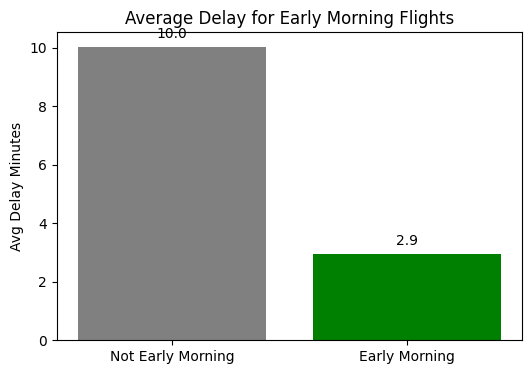

In [0]:
early_eda = (
    df.groupBy("IS_EARLY_MORNING")
      .agg(F.avg("DEP_DELAY").alias("avg_delay"))
      .orderBy("IS_EARLY_MORNING")
      .toPandas()
)

labels = ["Not Early Morning", "Early Morning"]
values = early_eda["avg_delay"].tolist()

plt.figure(figsize=(6, 4))
bars = plt.bar(labels, values, color=["gray", "green"])
plt.title("Average Delay for Early Morning Flights")
plt.ylabel("Avg Delay Minutes")

for bar, val in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, val + 0.3,
             f"{val:.1f}", ha="center")

plt.show()


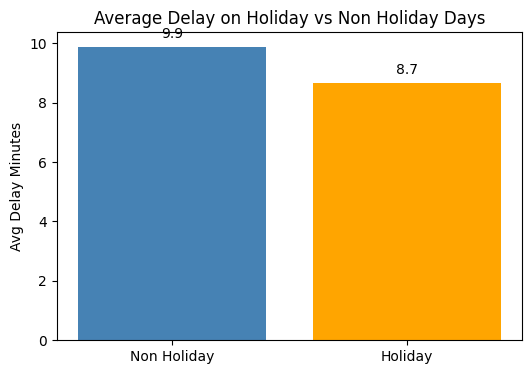

In [0]:
holiday_eda = (
    df.groupBy("IS_HOLIDAY")
      .agg(F.avg("DEP_DELAY").alias("avg_delay"),
           F.count("*").alias("flights"))
      .orderBy("IS_HOLIDAY")
      .toPandas()
)

labels = ["Non Holiday", "Holiday"]
values = holiday_eda["avg_delay"].tolist()

plt.figure(figsize=(6, 4))
plt.bar(labels, values, color=["steelblue", "orange"])
plt.title("Average Delay on Holiday vs Non Holiday Days")
plt.ylabel("Avg Delay Minutes")

for i, v in enumerate(values):
    plt.text(i, v + 0.3, f"{v:.1f}", ha="center")

plt.show()


#### Weather

In [0]:
df = df.withColumn(
    "FOG_RISK",
    F.when((F.col("HourlyVisibility") < 3) & (F.col("HourlyRelativeHumidity") >= 90), 1).otherwise(0)
)
df = df.withColumn(
    "STORM_RISK",
    F.when((F.col("HourlyWindSpeed") >= 15) & (F.col("HourlyRelativeHumidity") >= 80), 1).otherwise(0)
)

df = df.withColumn(
    "INT_VISIBILITY_HUMIDITY",
    F.col("HourlyVisibility") * F.col("HourlyRelativeHumidity")
)

df = df.withColumn(
    "INT_WIND_HUMIDITY",
    F.col("HourlyWindSpeed") * F.col("HourlyRelativeHumidity")
)


/root/.ipykernel/10446/command-1920497510758636-1884929222:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=["No Fog","Fog"], y=fog_pdf["avg_delay"], palette="Blues")


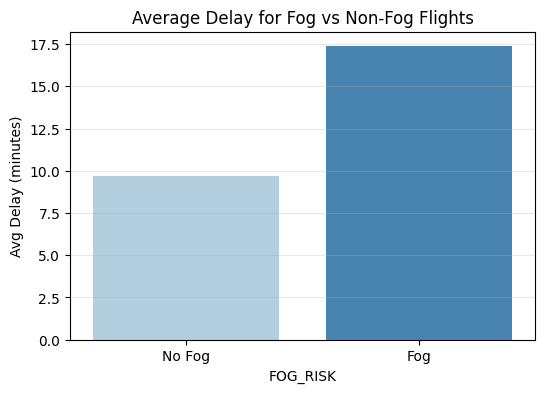

   FOG_RISK  avg_delay   flights
0         0   9.691052  30571331
1         1  17.367387    625999


/root/.ipykernel/10446/command-1920497510758636-1884929222:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=["No Storm Risk","Storm Risk"], y=storm_pdf["avg_delay"], palette="Reds")


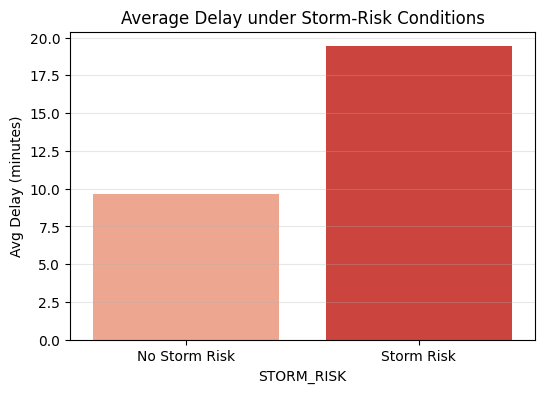

   STORM_RISK  avg_delay   flights
0           0   9.622180  30487151
1           1  19.414089    710179


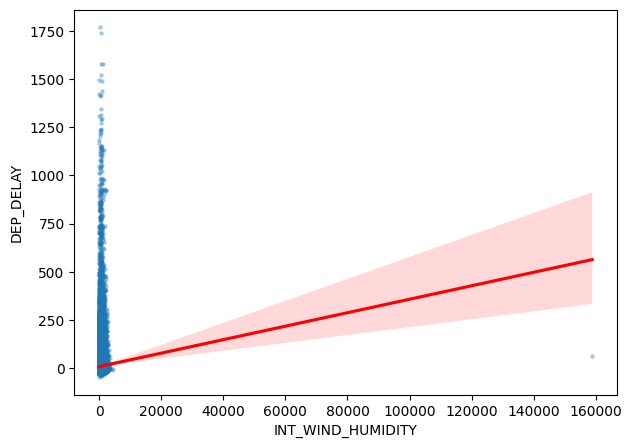

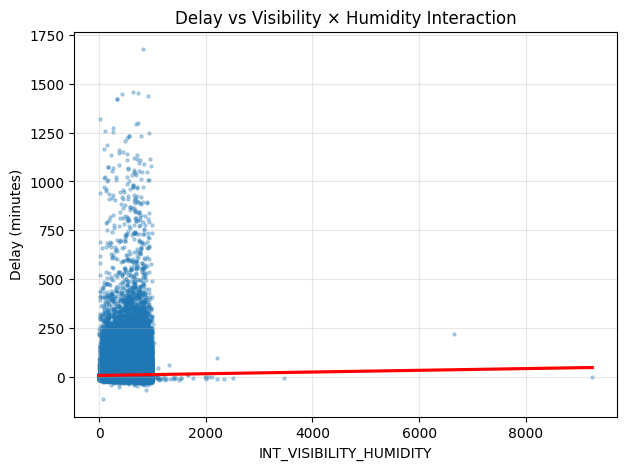

In [0]:
fog_pdf = (
    df.groupBy("FOG_RISK")
      .agg(F.avg("DEP_DELAY").alias("avg_delay"),
           F.count("*").alias("flights"))
      .orderBy("FOG_RISK")
      .toPandas()
)

plt.figure(figsize=(6,4))
sns.barplot(x=["No Fog","Fog"], y=fog_pdf["avg_delay"], palette="Blues")
plt.title("Average Delay for Fog vs Non-Fog Flights")
plt.ylabel("Avg Delay (minutes)")
plt.xlabel("FOG_RISK")
plt.grid(axis="y", alpha=0.3)
plt.show()

print(fog_pdf)
storm_pdf = (
    df.groupBy("STORM_RISK")
      .agg(F.avg("DEP_DELAY").alias("avg_delay"),
           F.count("*").alias("flights"))
      .orderBy("STORM_RISK")
      .toPandas()
)

plt.figure(figsize=(6,4))
sns.barplot(x=["No Storm Risk","Storm Risk"], y=storm_pdf["avg_delay"], palette="Reds")
plt.title("Average Delay under Storm-Risk Conditions")
plt.ylabel("Avg Delay (minutes)")
plt.xlabel("STORM_RISK")
plt.grid(axis="y", alpha=0.3)
plt.show()

print(storm_pdf)

sample2 = (
    df.select("INT_WIND_HUMIDITY","DEP_DELAY")
      .sample(0.01, seed=42)
      .toPandas()
)

plt.figure(figsize=(7,5))
sns.regplot(
    data=sample2,
    x="INT_WIND_HUMIDITY",
    y="DEP_DELAY",
    scatter_kws={"s": 5, "alpha": 0.3},
    line_kws={"color": "red"}
)

sample = (
    df.select("INT_VISIBILITY_HUMIDITY","DEP_DELAY")
      .sample(0.01, seed=42)
      .toPandas()
)

plt.figure(figsize=(7,5))
sns.regplot(
    data=sample,
    x="INT_VISIBILITY_HUMIDITY",
    y="DEP_DELAY",
    scatter_kws={"s": 5, "alpha": 0.3},
    line_kws={"color": "red"}
)
plt.title("Delay vs Visibility × Humidity Interaction")
plt.xlabel("INT_VISIBILITY_HUMIDITY")
plt.ylabel("Delay (minutes)")
plt.grid(True, alpha=0.3)
plt.show()

In [0]:
# Mark delayed flights
df = df.withColumn("is_delayed", F.when(F.col("DEP_DELAY") > 15, 1).otherwise(0))

# Need timestamp
df = df.withColumn("FL_DATE_TS", F.to_timestamp("FL_DATE"))

# 7-day rolling window (exclude current day)
w_carrier_7d = (
    Window.partitionBy("OP_UNIQUE_CARRIER")
          .orderBy(F.col("FL_DATE_TS").cast("long"))
          .rangeBetween(-7 * 86400, -1)
)

# Bayesian smoothing parameters
alpha = 10
prior_delay_rate = 0.15

df = df.withColumn(
    "carrier_delay_freq_7d",
    (F.sum("is_delayed").over(w_carrier_7d) + alpha * prior_delay_rate) /
    (F.count("*").over(w_carrier_7d) + alpha)
)


In [0]:
# Define route
df = df.withColumn("ROUTE", F.concat_ws("_", "ORIGIN", "DEST"))

# 30-day rolling window per carrier-route
w_route_30d = (
    Window.partitionBy("ROUTE", "OP_UNIQUE_CARRIER")
          .orderBy(F.col("FL_DATE_TS").cast("long"))
          .rangeBetween(-30 * 86400, -1)
)

df = df.withColumn(
    "carrier_route_delay_freq_30d",
    (F.sum("is_delayed").over(w_route_30d) + alpha * prior_delay_rate) /
    (F.count("*").over(w_route_30d) + alpha)
)


In [0]:
# Convert needed columns to Pandas
plot_pd = (
    df.select(
        "DEP_DELAY",
        "carrier_delay_freq_7d",
        "carrier_route_delay_freq_30d"
    )
    .where(F.col("DEP_DELAY").isNotNull())
    .toPandas()
)

# Scatter: carrier_delay_freq_7d vs DEP_DELAY
plt.figure(figsize=(6, 4))
plt.scatter(
    plot_pd["carrier_delay_freq_7d"],
    plot_pd["DEP_DELAY"],
    alpha=0.3
)
plt.xlabel("Carrier Delay Frequency (7-day)")
plt.ylabel("Departure Delay (minutes)")
plt.title("Carrier 7-Day Delay Frequency vs DEP_DELAY")
plt.tight_layout()
plt.show()

# Scatter: carrier_route_delay_freq_30d vs DEP_DELAY
plt.figure(figsize=(6, 4))
plt.scatter(
    plot_pd["carrier_route_delay_freq_30d"],
    plot_pd["DEP_DELAY"],
    alpha=0.3
)
plt.xlabel("Carrier–Route Delay Frequency (30-day)")
plt.ylabel("Departure Delay (minutes)")
plt.title("Carrier–Route 30-Day Delay Frequency vs DEP_DELAY")
plt.tight_layout()
plt.show()


In [0]:
# Unique airport nodes
v = (
    df.select(F.col("ORIGIN").alias("id"))
      .union(df.select(F.col("DEST").alias("id")))
      .distinct()
)

# Directed edges (ORIGIN -> DEST)
e = (
    df.select(
        F.col("ORIGIN").alias("src"),
        F.col("DEST").alias("dst")
    )
)

g = GraphFrame(v, e)
pagerank = g.pageRank(resetProbability=0.15, maxIter=20).vertices
pagerank = pagerank.select("id", F.col("pagerank").alias("ORIGIN_AIRPORT_PAGERANK"))

df = df.join(pagerank, df.ORIGIN == pagerank.id, "left").drop("id")


In [0]:
# Convert PageRank + DEP_DELAY to Pandas
plot_pd = (
    df.select("ORIGIN_AIRPORT_PAGERANK", "DEP_DELAY")
      .where(
          F.col("ORIGIN_AIRPORT_PAGERANK").isNotNull() &
          F.col("DEP_DELAY").isNotNull()
      )
      .toPandas()
)

# Scatter: PageRank vs DEP_DELAY
plt.figure(figsize=(8, 4))
plt.scatter(
    plot_pd["ORIGIN_AIRPORT_PAGERANK"],
    plot_pd["DEP_DELAY"],
    alpha=0.3
)

plt.title("Origin Airport PageRank vs Departure Delay")
plt.xlabel("Origin Airport PageRank")
plt.ylabel("Departure Delay (minutes)")
plt.tight_layout()
plt.show()


### Final Features Selection

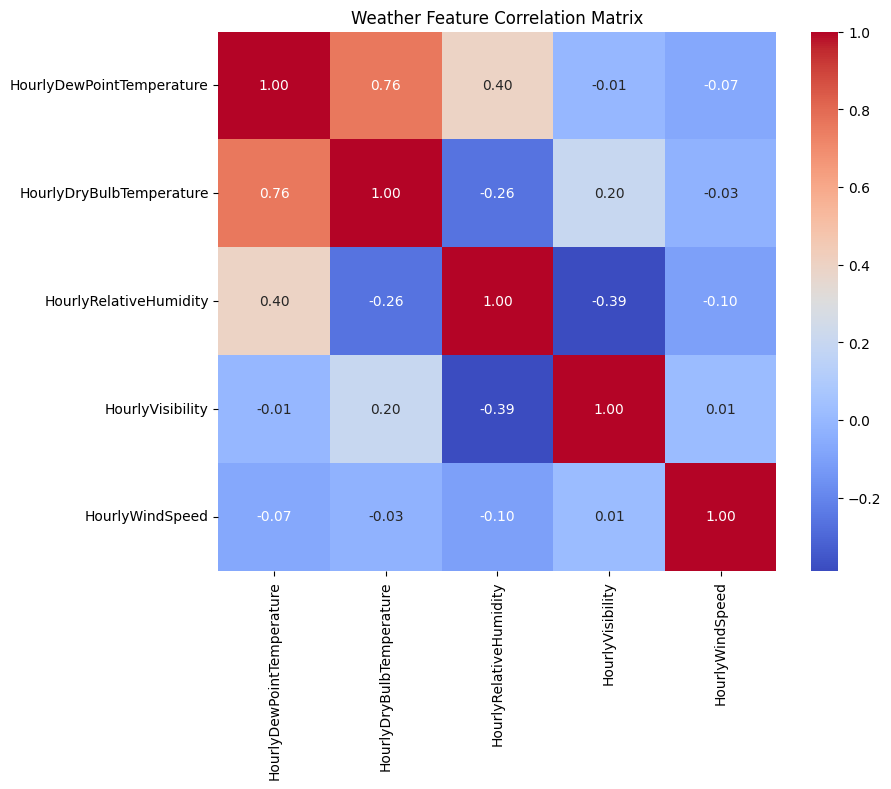

In [0]:
sample_pdf = (
    df.select(weather_cols)
      .sample(fraction=0.02, seed=42)
      .toPandas()
)
corr = sample_pdf.corr()
plt.figure(figsize=(9,7))
sns.heatmap(corr, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Weather Feature Correlation Matrix")
plt.show()


In [0]:
target = "DEP_DELAY"

numeric_features = [
    "FOG_RISK",
    "STORM_RISK",
    "INT_VISIBILITY_HUMIDITY",
    "INT_WIND_HUMIDITY",
    "carrier_delay_freq_7d",
    "carrier_route_delay_freq_30d",
    "ORIGIN_AIRPORT_PAGERANK",
    "CRS_ELAPSED_TIME",
    "DISTANCE",
]

categorical_features = [
    "OP_UNIQUE_CARRIER",
    "ORIGIN",
    "DEST",
    "HOUR_OF_DAY",
    "SEASON",
    "DAY_OF_WEEK",
]

binary_features = [
    "IS_HOLIDAY",
    "IS_EARLY_MORNING",
    "IS_PEAK_HOUR"
]

split_columns = ["YEAR"]

final_features = (
    numeric_features +
    categorical_features +
    binary_features
)

final_columns = [target] + split_columns + final_features

df_final = df.select(final_columns)

print("Final DF Columns:", df_final.columns)
print(f"Total columns: {len(df_final.columns)}")


Final DF Columns: ['DEP_DELAY', 'YEAR', 'FOG_RISK', 'STORM_RISK', 'INT_VISIBILITY_HUMIDITY', 'INT_WIND_HUMIDITY', 'carrier_delay_freq_7d', 'carrier_route_delay_freq_30d', 'ORIGIN_AIRPORT_PAGERANK', 'CRS_ELAPSED_TIME', 'DISTANCE', 'OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST', 'HOUR_OF_DAY', 'SEASON', 'DAY_OF_WEEK', 'IS_HOLIDAY', 'IS_EARLY_MORNING', 'IS_PEAK_HOUR']
Total columns: 20


In [0]:
section = "3"
number = "3"
folder_path = f"dbfs:/student-groups/Group_{section}_{number}"
dbutils.fs.mkdirs(folder_path)

df_final.write.mode("overwrite").parquet(
    f"{folder_path}/df_otpw_60m_final.parquet"
)


### Train/Validation/Test Split (Time-Based)

In [0]:
# load cleaned and feature engineered datasets
base_path = "dbfs:/student-groups/Group_3_3"

df_final  = spark.read.parquet(f"{base_path}/df_otpw_60m_final.parquet")





In [0]:
target = "DEP_DELAY"

numeric_features = [
    "FOG_RISK",
    "STORM_RISK",
    "INT_VISIBILITY_HUMIDITY",
    "INT_WIND_HUMIDITY",
    "carrier_delay_freq_7d",
    "carrier_route_delay_freq_30d",
    "ORIGIN_AIRPORT_PAGERANK",
    "CRS_ELAPSED_TIME",
    "DISTANCE",
]

categorical_features = [
    "OP_UNIQUE_CARRIER",
    "ORIGIN",
    "DEST",
    "HOUR_OF_DAY",
    "SEASON",
    "DAY_OF_WEEK",
]


binary_features = [
    "IS_HOLIDAY",
    "IS_EARLY_MORNING",
    "IS_PEAK_HOUR"
]


Train/Val/Test Split (time-based)

In [0]:
cv_df   = df_final.filter(F.col("YEAR").between(2015, 2018)).cache()
test_df = df_final.filter(F.col("YEAR") == 2019).cache()

# Expanding-window folds
folds = [
    {"train_years": [2015],               "val_years": [2016]},
    {"train_years": [2015, 2016],         "val_years": [2017]},
    {"train_years": [2015, 2016, 2017],   "val_years": [2018]},
]

Preprocessing Pipeline

In [0]:
def build_preprocess_pipeline():

    indexers = [
        StringIndexer(
            inputCol=c,
            outputCol=f"{c}_idx",
            handleInvalid="keep"
        )
        for c in categorical_features
    ]
    
    numeric_assembler = VectorAssembler(
        inputCols=numeric_features,
        outputCol="numeric_vec",
        handleInvalid="skip"
    )
    
    scaler = StandardScaler(
        inputCol="numeric_vec",
        outputCol="numeric_scaled",
        withMean=True,
        withStd=True
    )

    final_inputs = ["numeric_scaled"] + binary_features + [f"{c}_idx" for c in categorical_features]

    final_assembler = VectorAssembler(
        inputCols=final_inputs,
        outputCol="features",
        handleInvalid="keep"
    )

    return Pipeline(stages=indexers + [numeric_assembler, scaler, final_assembler])


evaluator

In [0]:
rmse_eval = RegressionEvaluator(
    labelCol="DEP_DELAY",
    predictionCol="prediction",
    metricName="rmse"
)

mae_eval = RegressionEvaluator(
    labelCol="DEP_DELAY",
    predictionCol="prediction",
    metricName="mae"
)


baseline

In [0]:
lr_train = cv_df.filter(F.col("YEAR") <= 2017)
lr_val   = cv_df.filter(F.col("YEAR") == 2018)

In [0]:


lr_pp = build_preprocess_pipeline().fit(lr_train)

# Transform train + validation
lr_train_pp = lr_pp.transform(lr_train)
lr_val_pp   = lr_pp.transform(lr_val)

lr = LinearRegression(featuresCol="features", labelCol=target)
lr_model = lr.fit(lr_train_pp)
val_pred = lr_model.transform(lr_val_pp)

print("\nLR Validation RMSE:", rmse_eval.evaluate(val_pred))
print("LR Validation MAE:", mae_eval.evaluate(val_pred))

lr_test = lr_pp.transform(test_df)
lr_test_pred = lr_model.transform(lr_test)

print("\nLR Test RMSE:", rmse_eval.evaluate(lr_test_pred))
print("LR Test MAE:", mae_eval.evaluate(lr_test_pred))


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]


LR Validation RMSE: 44.10947787461023
LR Validation MAE: 19.783204950166784

LR Test RMSE: 48.30339302328071
LR Test MAE: 20.776904551710896


GBT

In [0]:
def fit_gbt_with_time_cv(df_cv, folds, grid, patience=1):

    preprocess = build_preprocess_pipeline()

    results = []
    from itertools import product

    # Separate maxIter for early stopping
    param_keys = list(grid.keys())
    param_values = list(grid.values())

    idx = param_keys.index("maxIter")
    maxIter_list = sorted(param_values[idx])
    param_keys.pop(idx)
    param_values.pop(idx)

    # Parameter combinations excluding maxIter
    for combo in product(*param_values):
        base_params = dict(zip(param_keys, combo))
        print(f"\nGBT Config: {base_params}")

        best_rmse = float("inf")
        best_mae = float("inf")
        best_params_for_combo = None
        no_improve = 0

        for trees in maxIter_list:
            print(f"  Trying maxIter = {trees} ...")
            rmses = []
            maes  = []

            for f in folds:

                # Train/val raw splits
                train_raw = df_cv.filter(F.col("YEAR").isin(f["train_years"]))
                val_raw   = df_cv.filter(F.col("YEAR").isin(f["val_years"]))

                # Fit preprocessing ONLY on train to prevent leakage
                pp = preprocess.fit(train_raw)

                train = pp.transform(train_raw)
                val   = pp.transform(val_raw)

                params = dict(base_params)
                params["maxIter"] = trees

                gbt = GBTRegressor(
                    labelCol=target,
                    featuresCol="features",
                    **params
                )

                model = gbt.fit(train)
                pred = model.transform(val)

                rmse = rmse_eval.evaluate(pred)
                mae  = mae_eval.evaluate(pred)

                rmses.append(rmse)
                maes.append(mae)

                print(f"    Fold {f['train_years']}→{f['val_years']} | RMSE={rmse:.4f}, MAE={mae:.4f}")

            avg_rmse = float(np.mean(rmses))
            avg_mae  = float(np.mean(maes))

            print(f"  → Avg RMSE for maxIter={trees} = {avg_rmse:.4f}")
            print(f"    Avg MAE  for maxIter={trees} = {avg_mae:.4f}")

            if avg_rmse < best_rmse:
                best_rmse = avg_rmse
                best_mae = avg_mae
                best_params_for_combo = params
                no_improve = 0
            else:
                no_improve += 1
                if no_improve >= patience:
                    break

        print(f"\n  Best for this config:")
        print(f"    RMSE={best_rmse:.4f}, MAE={best_mae:.4f}")
        print(f"    params={best_params_for_combo}")

        results.append((best_params_for_combo, best_rmse, best_mae))

    # Pick best overall
    best_params, best_cv_rmse, best_cv_mae = sorted(results, key=lambda x: x[1])[0]

    # Final preprocessing fit on FULL CV set
    final_pp = build_preprocess_pipeline().fit(df_cv)
    cv_final = final_pp.transform(df_cv)

    final_model = GBTRegressor(
        labelCol=target,
        featuresCol="features",
        **best_params
    ).fit(cv_final)

    return final_model, final_pp, best_cv_rmse, best_cv_mae, best_params


In [0]:
gbt_param_grid = {
    "maxIter": [40, 80, 120, 160],
    "maxDepth": [5],
    "minInstancesPerNode": [5],
    "stepSize": [0.05],
    "maxBins": [512]
}

best_gbt, gbt_pp, gbt_cv_rmse, gbt_cv_mae, gbt_params = fit_gbt_with_time_cv(cv_df, folds, gbt_param_grid)

test_pp = gbt_pp.transform(test_df)
test_pred = best_gbt.transform(test_pp)

gbt_test_rmse = rmse_eval.evaluate(test_pred)
gbt_test_mae  = mae_eval.evaluate(test_pred)

print(f"\nGBT Test RMSE={gbt_test_rmse:.4f}, MAE={gbt_test_mae:.4f}")



GBT Config: {'maxDepth': 5, 'minInstancesPerNode': 5, 'stepSize': 0.05, 'maxBins': 512}
  Trying maxIter = 40 ...


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

    Fold [2015]→[2016] | RMSE=38.8831, MAE=17.4708


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

    Fold [2015, 2016]→[2017] | RMSE=42.8744, MAE=18.7844


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

    Fold [2015, 2016, 2017]→[2018] | RMSE=43.8905, MAE=19.6788
  → Avg RMSE for maxIter=40 = 41.8827
    Avg MAE  for maxIter=40 = 18.6447
  Trying maxIter = 80 ...


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

    Fold [2015]→[2016] | RMSE=38.8617, MAE=17.4876


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

    Fold [2015, 2016]→[2017] | RMSE=42.8297, MAE=18.7730


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

    Fold [2015, 2016, 2017]→[2018] | RMSE=43.8982, MAE=19.7816
  → Avg RMSE for maxIter=80 = 41.8632
    Avg MAE  for maxIter=80 = 18.6807
  Trying maxIter = 120 ...


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

    Fold [2015]→[2016] | RMSE=38.8677, MAE=17.5015


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

    Fold [2015, 2016]→[2017] | RMSE=42.8246, MAE=18.7773


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

    Fold [2015, 2016, 2017]→[2018] | RMSE=44.0031, MAE=19.8912
  → Avg RMSE for maxIter=120 = 41.8984
    Avg MAE  for maxIter=120 = 18.7233

  Best for this config:
    RMSE=41.8632, MAE=18.6807
    params={'maxDepth': 5, 'minInstancesPerNode': 5, 'stepSize': 0.05, 'maxBins': 512, 'maxIter': 80}


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]


GBT Test RMSE=48.0088, MAE=20.4542


In [0]:
def get_feature_names():
    return numeric_features + binary_features + [f"{c}_idx" for c in categorical_features]

feature_names = get_feature_names()
importances = best_gbt.featureImportances.toArray()

fi_df = pd.DataFrame({"feature": feature_names, "importance": importances})
fi_df = fi_df.sort_values("importance", ascending=False)

print("\nTOP 10 GBT FEATURES:")
print(fi_df.head(10))


TOP 10 GBT FEATURES:
                         feature  importance
13                    ORIGIN_idx    0.235518
15               HOUR_OF_DAY_idx    0.200635
14                      DEST_idx    0.095004
2        INT_VISIBILITY_HUMIDITY    0.092165
5   carrier_route_delay_freq_30d    0.071709
16                    SEASON_idx    0.062639
3              INT_WIND_HUMIDITY    0.060752
4          carrier_delay_freq_7d    0.059860
17               DAY_OF_WEEK_idx    0.044024
12         OP_UNIQUE_CARRIER_idx    0.033627


MLP

In [0]:
class MLPPreprocessor:
    def __init__(self, numeric_features, categorical_features, binary_features, target):
        self.numeric_features = numeric_features
        self.categorical_features = categorical_features
        self.binary_features = binary_features
        self.target = target

        self.means = {}
        self.stds = {}
        self.vocabs = {}

    def fit(self, pdf):
        for col in self.numeric_features:
            col_series = pdf[col]
            mean = col_series.mean()
            std = col_series.std()

            if pd.isna(mean): 
                mean = 0.0
            if pd.isna(std) or std < 1e-6: 
                std = 1.0

            self.means[col] = float(mean)
            self.stds[col] = float(std)

        for col in self.categorical_features:
            pdf[col] = pdf[col].astype(str)
            uniq = pdf[col].unique()
            self.vocabs[col] = {v: i for i, v in enumerate(uniq)}

    def transform(self, pdf):
        for col in self.categorical_features:
            pdf[col] = pdf[col].astype(str)

        X_num_list = []
        for col in self.numeric_features:
            vals = pdf[col].fillna(self.means[col]).to_numpy(dtype="float32")
            norm = (vals - self.means[col]) / self.stds[col]
            norm = np.nan_to_num(norm)
            X_num_list.append(norm)
        X_num = np.stack(X_num_list, axis=1).astype("float32")

        X_bin = pdf[self.binary_features].fillna(0).astype("float32").to_numpy()

        X_cat_list = []
        for col in self.categorical_features:
            vocab = self.vocabs[col]
            encoded = pdf[col].map(vocab).fillna(-1).astype("int32").to_numpy()
            encoded = np.nan_to_num(encoded, nan=-1).astype("int32")
            X_cat_list.append(encoded)
        X_cat = np.stack(X_cat_list, axis=1).astype("float32")

        X_np = np.concatenate([X_num, X_bin, X_cat], axis=1).astype("float32")
        X_np = np.nan_to_num(X_np)

        y_np = pdf[self.target].fillna(0).astype("float32").to_numpy()
        y_np = np.nan_to_num(y_np)

        return torch.tensor(X_np, dtype=torch.float32, device="cpu"), \
               torch.tensor(y_np, dtype=torch.float32, device="cpu")

In [0]:
class MLP(nn.Module):
    def __init__(self, num_features, hidden_dims):
        super().__init__()
        layers = []
        in_dim = num_features

        for h in hidden_dims:
            layers.append(nn.Linear(in_dim, h))
            layers.append(nn.ReLU())
            in_dim = h

        layers.append(nn.Linear(in_dim, 1))
        self.net = nn.Sequential(*layers).to(device)

    def forward(self, x):
        return self.net(x)

In [0]:
def train_mlp_single_fold(
    hidden_dims, lr, train_X, train_y, val_X, val_y,
    batch_size=131072,
    epochs=150,
    patience=3
):

    num_features = train_X.shape[1]
    model = MLP(num_features, hidden_dims).to(device)

    train_dl = DataLoader(
        TensorDataset(train_X, train_y),
        batch_size=batch_size, shuffle=True,
        pin_memory=True, num_workers=8, persistent_workers=True, prefetch_factor=4
    )

    val_dl = DataLoader(
        TensorDataset(val_X, val_y),
        batch_size=batch_size, shuffle=False,
        pin_memory=True, num_workers=8, persistent_workers=True, prefetch_factor=4
    )

    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    scaler = torch.cuda.amp.GradScaler()

    best_rmse = float("inf")
    best_state = None
    wait = 0

    for epoch in range(1, epochs + 1):
        print(f"Epoch {epoch}")
        model.train()

        for xb, yb in train_dl:
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)

            opt.zero_grad()
            with torch.cuda.amp.autocast():
                pred = model(xb).squeeze()
                loss = loss_fn(pred, yb)

            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()

        # validation
        model.eval()
        preds, trues = [], []
        with torch.no_grad():
            for xb, yb in val_dl:
                xb = xb.to(device, non_blocking=True)
                with torch.cuda.amp.autocast():
                    pred = model(xb).squeeze()
                preds.append(pred.cpu().numpy())
                trues.append(yb.cpu().numpy())

        preds = np.concatenate(preds)
        trues = np.concatenate(trues)
        rmse = mean_squared_error(trues, preds, squared=False)

        print(f"  Val RMSE: {rmse:.5f} | Best: {best_rmse:.5f} | Wait: {wait}")

        if rmse < best_rmse:
            best_rmse = rmse
            best_state = model.state_dict()
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print("  Early stopping")
                break

    model.load_state_dict(best_state)
    return model, best_rmse

In [0]:
def cache_fold_tensors(cv_pdf, folds, save_to_disk=False):
    fold_tensors = []

    for i, fold in enumerate(folds):
        print(f"\n[Fold {i}] Train years = {fold['train_years']} → Val years = {fold['val_years']}")

        train_pdf = cv_pdf[cv_pdf["YEAR"].isin(fold["train_years"])]
        val_pdf   = cv_pdf[cv_pdf["YEAR"].isin(fold["val_years"])]

        pp = MLPPreprocessor(numeric_features, categorical_features, binary_features, target)
        pp.fit(train_pdf)

        train_X, train_y = pp.transform(train_pdf)
        val_X, val_y     = pp.transform(val_pdf)

        fd = {
            "meta": fold,
            "train_X": train_X,
            "train_y": train_y,
            "val_X": val_X,
            "val_y": val_y
        }

        if save_to_disk:
            torch.save(fd, f"dbfs:/student-groups/Group_3_3/fold_cache_{i}.pt")

        fold_tensors.append(fd)
        gc.collect()

    print("Finished all folds.")
    return fold_tensors

In [0]:
def mlp_time_cv_grid_search_cached(fold_tensors, arch_name, hidden_grid, lr_grid):

    results = []
    for hidden_dims in hidden_grid:
        for lr in lr_grid:
            print(f"\n{arch_name} — Hidden={hidden_dims}, LR={lr}")
            rmses = []

            for i, ft in enumerate(fold_tensors):
                print(f" Fold {i}")
                _, rmse = train_mlp_single_fold(
                    hidden_dims, lr,
                    ft["train_X"], ft["train_y"],
                    ft["val_X"], ft["val_y"]
                )
                rmses.append(rmse)

            avg_rmse = float(np.mean(rmses))

            print(f" → CV RMSE={avg_rmse:.5f}")

            results.append(((hidden_dims, lr), avg_rmse))

    best_params, best_rmse = min(results, key=lambda x: x[1])
    print(f"\nBest params: {best_params} | RMSE={best_rmse:.5f}")
    return best_params, best_rmse


In [0]:
def train_final_mlp(hidden_dims, lr, X_full, y_full, X_test, y_test):

    N = len(X_full)
    idx = torch.randperm(N)
    train_idx = idx[: int(0.9 * N)]
    val_idx   = idx[int(0.9 * N):]

    X_train = X_full[train_idx]
    y_train = y_full[train_idx]
    X_val   = X_full[val_idx]
    y_val   = y_full[val_idx]

    model, rmse = train_mlp_single_fold(
        hidden_dims, lr, X_train, y_train, X_val, y_val
    )

    preds = model(X_test.to(device)).squeeze().cpu().detach().numpy()
    trues = y_test.cpu().numpy()

    test_rmse = mean_squared_error(trues, preds, squared=False)
    test_mae  = mean_absolute_error(trues, preds)

    return model, rmse, test_rmse, test_mae

In [0]:
cv_pdf = cv_df.toPandas()
test_pdf = test_df.toPandas()



In [0]:
fold_tensors = cache_fold_tensors(cv_pdf, folds, save_to_disk=False)



[Fold 0] Train years = [2015] → Val years = [2016]


/root/.ipykernel/35255/command-4929639740558156-3127763131:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdf[col] = pdf[col].astype(str)
/root/.ipykernel/35255/command-4929639740558156-3127763131:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdf[col] = pdf[col].astype(str)
/root/.ipykernel/35255/command-4929639740558156-3127763131:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in


[Fold 1] Train years = [2015, 2016] → Val years = [2017]


/root/.ipykernel/35255/command-4929639740558156-3127763131:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdf[col] = pdf[col].astype(str)
/root/.ipykernel/35255/command-4929639740558156-3127763131:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdf[col] = pdf[col].astype(str)
/root/.ipykernel/35255/command-4929639740558156-3127763131:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in


[Fold 2] Train years = [2015, 2016, 2017] → Val years = [2018]


/root/.ipykernel/35255/command-4929639740558156-3127763131:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdf[col] = pdf[col].astype(str)
/root/.ipykernel/35255/command-4929639740558156-3127763131:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdf[col] = pdf[col].astype(str)
/root/.ipykernel/35255/command-4929639740558156-3127763131:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

Finished all folds.


In [0]:
mlp1_best, mlp1_rmse = mlp_time_cv_grid_search_cached(
    fold_tensors, "MLP-1", [[64], [128]], [1e-3]
)


MLP-1 — Hidden=[64], LR=0.001
 Fold 0
Epoch 1


/root/.ipykernel/35255/command-4929639740558156-3127763131:169: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.07374 | Best: inf | Wait: 0
Epoch 2


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.91233 | Best: 40.07374 | Wait: 0
Epoch 3


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.69280 | Best: 39.91233 | Wait: 0
Epoch 4


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.54028 | Best: 39.69280 | Wait: 0
Epoch 5


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.42291 | Best: 39.54028 | Wait: 0
Epoch 6


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.33733 | Best: 39.42291 | Wait: 0
Epoch 7


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.26945 | Best: 39.33733 | Wait: 0
Epoch 8


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.23254 | Best: 39.26945 | Wait: 0
Epoch 9


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.20285 | Best: 39.23254 | Wait: 0
Epoch 10


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.18478 | Best: 39.20285 | Wait: 0
Epoch 11


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.17651 | Best: 39.18478 | Wait: 0
Epoch 12


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.16250 | Best: 39.17651 | Wait: 0
Epoch 13


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.15033 | Best: 39.16250 | Wait: 0
Epoch 14


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.14031 | Best: 39.15033 | Wait: 0
Epoch 15


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.13486 | Best: 39.14031 | Wait: 0
Epoch 16


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.12921 | Best: 39.13486 | Wait: 0
Epoch 17


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.11889 | Best: 39.12921 | Wait: 0
Epoch 18


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.11330 | Best: 39.11889 | Wait: 0
Epoch 19


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.10910 | Best: 39.11330 | Wait: 0
Epoch 20


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.10381 | Best: 39.10910 | Wait: 0
Epoch 21


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.10180 | Best: 39.10381 | Wait: 0
Epoch 22


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.09355 | Best: 39.10180 | Wait: 0
Epoch 23


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.08830 | Best: 39.09355 | Wait: 0
Epoch 24


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.08458 | Best: 39.08830 | Wait: 0
Epoch 25


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.08750 | Best: 39.08458 | Wait: 0
Epoch 26


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.08061 | Best: 39.08458 | Wait: 1
Epoch 27


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.07584 | Best: 39.08061 | Wait: 0
Epoch 28


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.08120 | Best: 39.07584 | Wait: 0
Epoch 29


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.07112 | Best: 39.07584 | Wait: 1
Epoch 30


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.07155 | Best: 39.07112 | Wait: 0
Epoch 31


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.06638 | Best: 39.07112 | Wait: 1
Epoch 32


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.06416 | Best: 39.06638 | Wait: 0
Epoch 33


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.06525 | Best: 39.06416 | Wait: 0
Epoch 34


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.06358 | Best: 39.06416 | Wait: 1
Epoch 35


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.06260 | Best: 39.06358 | Wait: 0
Epoch 36


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.06010 | Best: 39.06260 | Wait: 0
Epoch 37


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.06226 | Best: 39.06010 | Wait: 0
Epoch 38


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.05566 | Best: 39.06010 | Wait: 1
Epoch 39


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.05519 | Best: 39.05566 | Wait: 0
Epoch 40


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.06045 | Best: 39.05519 | Wait: 0
Epoch 41


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.05697 | Best: 39.05519 | Wait: 1
Epoch 42


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.05180 | Best: 39.05519 | Wait: 2
Epoch 43


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.05344 | Best: 39.05180 | Wait: 0
Epoch 44


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.05121 | Best: 39.05180 | Wait: 1
Epoch 45


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.05253 | Best: 39.05121 | Wait: 0
Epoch 46


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.05510 | Best: 39.05121 | Wait: 1
Epoch 47


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.05082 | Best: 39.05121 | Wait: 2
Epoch 48


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.05054 | Best: 39.05082 | Wait: 0
Epoch 49


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.05157 | Best: 39.05054 | Wait: 0
Epoch 50


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.04816 | Best: 39.05054 | Wait: 1
Epoch 51


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.04705 | Best: 39.04816 | Wait: 0
Epoch 52


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.05786 | Best: 39.04705 | Wait: 0
Epoch 53


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.04692 | Best: 39.04705 | Wait: 1
Epoch 54


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.05881 | Best: 39.04692 | Wait: 0
Epoch 55


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.04454 | Best: 39.04692 | Wait: 1
Epoch 56


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.04694 | Best: 39.04454 | Wait: 0
Epoch 57


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.04742 | Best: 39.04454 | Wait: 1
Epoch 58


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  Val RMSE: 39.04622 | Best: 39.04454 | Wait: 2
  Early stopping


/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


 Fold 1
Epoch 1


/root/.ipykernel/35255/command-4929639740558156-3127763131:169: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 43.97635 | Best: inf | Wait: 0
Epoch 2


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 43.65384 | Best: 43.97635 | Wait: 0
Epoch 3


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 43.44203 | Best: 43.65384 | Wait: 0
Epoch 4


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 43.32069 | Best: 43.44203 | Wait: 0
Epoch 5


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 43.25385 | Best: 43.32069 | Wait: 0
Epoch 6


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 43.21450 | Best: 43.25385 | Wait: 0
Epoch 7


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 43.19874 | Best: 43.21450 | Wait: 0
Epoch 8


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 43.18282 | Best: 43.19874 | Wait: 0
Epoch 9


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 43.16024 | Best: 43.18282 | Wait: 0
Epoch 10


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 43.15758 | Best: 43.16024 | Wait: 0
Epoch 11


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 43.15172 | Best: 43.15758 | Wait: 0
Epoch 12


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 43.13581 | Best: 43.15172 | Wait: 0
Epoch 13


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 43.12292 | Best: 43.13581 | Wait: 0
Epoch 14


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 43.10935 | Best: 43.12292 | Wait: 0
Epoch 15


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 43.09581 | Best: 43.10935 | Wait: 0
Epoch 16


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 43.09518 | Best: 43.09581 | Wait: 0
Epoch 17


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 43.08689 | Best: 43.09518 | Wait: 0
Epoch 18


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 43.08340 | Best: 43.08689 | Wait: 0
Epoch 19


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 43.08160 | Best: 43.08340 | Wait: 0
Epoch 20


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 43.08162 | Best: 43.08160 | Wait: 0
Epoch 21


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 43.07684 | Best: 43.08160 | Wait: 1
Epoch 22


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 43.07796 | Best: 43.07684 | Wait: 0
Epoch 23


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 43.07130 | Best: 43.07684 | Wait: 1
Epoch 24


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 43.07299 | Best: 43.07130 | Wait: 0
Epoch 25


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 43.07108 | Best: 43.07130 | Wait: 1
Epoch 26


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 43.08027 | Best: 43.07108 | Wait: 0
Epoch 27


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 43.06485 | Best: 43.07108 | Wait: 1
Epoch 28


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 43.07249 | Best: 43.06485 | Wait: 0
Epoch 29


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 43.06664 | Best: 43.06485 | Wait: 1
Epoch 30


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 43.06926 | Best: 43.06485 | Wait: 2
  Early stopping
 Fold 2
Epoch 1


/root/.ipykernel/35255/command-4929639740558156-3127763131:169: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.86458 | Best: inf | Wait: 0
Epoch 2


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.55275 | Best: 44.86458 | Wait: 0
Epoch 3


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.31635 | Best: 44.55275 | Wait: 0
Epoch 4


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.24632 | Best: 44.31635 | Wait: 0
Epoch 5


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.20796 | Best: 44.24632 | Wait: 0
Epoch 6


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.18215 | Best: 44.20796 | Wait: 0
Epoch 7


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.16563 | Best: 44.18215 | Wait: 0
Epoch 8


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.14447 | Best: 44.16563 | Wait: 0
Epoch 9


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.13353 | Best: 44.14447 | Wait: 0
Epoch 10


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.12505 | Best: 44.13353 | Wait: 0
Epoch 11


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.11709 | Best: 44.12505 | Wait: 0
Epoch 12


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.11177 | Best: 44.11709 | Wait: 0
Epoch 13


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.10791 | Best: 44.11177 | Wait: 0
Epoch 14


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.10119 | Best: 44.10791 | Wait: 0
Epoch 15


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.09768 | Best: 44.10119 | Wait: 0
Epoch 16


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.09333 | Best: 44.09768 | Wait: 0
Epoch 17


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.09246 | Best: 44.09333 | Wait: 0
Epoch 18


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.08920 | Best: 44.09246 | Wait: 0
Epoch 19


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.08425 | Best: 44.08920 | Wait: 0
Epoch 20


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.08347 | Best: 44.08425 | Wait: 0
Epoch 21


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.08358 | Best: 44.08347 | Wait: 0
Epoch 22


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.07746 | Best: 44.08347 | Wait: 1
Epoch 23


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.07531 | Best: 44.07746 | Wait: 0
Epoch 24


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.07412 | Best: 44.07531 | Wait: 0
Epoch 25


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.07291 | Best: 44.07412 | Wait: 0
Epoch 26


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.07063 | Best: 44.07291 | Wait: 0
Epoch 27


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.07291 | Best: 44.07063 | Wait: 0
Epoch 28


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.06818 | Best: 44.07063 | Wait: 1
Epoch 29


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.06775 | Best: 44.06818 | Wait: 0
Epoch 30


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.06695 | Best: 44.06775 | Wait: 0
Epoch 31


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.06687 | Best: 44.06695 | Wait: 0
Epoch 32


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.06624 | Best: 44.06687 | Wait: 0
Epoch 33


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.06439 | Best: 44.06624 | Wait: 0
Epoch 34


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.06239 | Best: 44.06439 | Wait: 0
Epoch 35


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.06278 | Best: 44.06239 | Wait: 0
Epoch 36


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.06250 | Best: 44.06239 | Wait: 1
Epoch 37


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.06065 | Best: 44.06239 | Wait: 2
Epoch 38


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.06023 | Best: 44.06065 | Wait: 0
Epoch 39


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.06078 | Best: 44.06023 | Wait: 0
Epoch 40


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.05672 | Best: 44.06023 | Wait: 1
Epoch 41


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.05791 | Best: 44.05672 | Wait: 0
Epoch 42


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.05619 | Best: 44.05672 | Wait: 1
Epoch 43


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.05488 | Best: 44.05619 | Wait: 0
Epoch 44


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.05338 | Best: 44.05488 | Wait: 0
Epoch 45


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.05609 | Best: 44.05338 | Wait: 0
Epoch 46


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.05381 | Best: 44.05338 | Wait: 1
Epoch 47


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.05404 | Best: 44.05338 | Wait: 2
  Early stopping
 → CV RMSE=42.05426

MLP-1 — Hidden=[128], LR=0.001
 Fold 0
Epoch 1


/root/.ipykernel/35255/command-4929639740558156-3127763131:169: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.96341 | Best: inf | Wait: 0
Epoch 2


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.71980 | Best: 39.96341 | Wait: 0
Epoch 3


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.52256 | Best: 39.71980 | Wait: 0
Epoch 4


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.36760 | Best: 39.52256 | Wait: 0
Epoch 5


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.27438 | Best: 39.36760 | Wait: 0
Epoch 6


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.22086 | Best: 39.27438 | Wait: 0
Epoch 7


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.19983 | Best: 39.22086 | Wait: 0
Epoch 8


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.17568 | Best: 39.19983 | Wait: 0
Epoch 9


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.16190 | Best: 39.17568 | Wait: 0
Epoch 10


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.14894 | Best: 39.16190 | Wait: 0
Epoch 11


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.13356 | Best: 39.14894 | Wait: 0
Epoch 12


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.12173 | Best: 39.13356 | Wait: 0
Epoch 13


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.11626 | Best: 39.12173 | Wait: 0
Epoch 14


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.11198 | Best: 39.11626 | Wait: 0
Epoch 15


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.09760 | Best: 39.11198 | Wait: 0
Epoch 16


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.09996 | Best: 39.09760 | Wait: 0
Epoch 17


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.08847 | Best: 39.09760 | Wait: 1
Epoch 18


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.08294 | Best: 39.08847 | Wait: 0
Epoch 19


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.07923 | Best: 39.08294 | Wait: 0
Epoch 20


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.07427 | Best: 39.07923 | Wait: 0
Epoch 21


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.07288 | Best: 39.07427 | Wait: 0
Epoch 22


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.07004 | Best: 39.07288 | Wait: 0
Epoch 23


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.06582 | Best: 39.07004 | Wait: 0
Epoch 24


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.07034 | Best: 39.06582 | Wait: 0
Epoch 25


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.06039 | Best: 39.06582 | Wait: 1
Epoch 26


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.05948 | Best: 39.06039 | Wait: 0
Epoch 27


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.05458 | Best: 39.05948 | Wait: 0
Epoch 28


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.05693 | Best: 39.05458 | Wait: 0
Epoch 29


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.05514 | Best: 39.05458 | Wait: 1
Epoch 30


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.05266 | Best: 39.05458 | Wait: 2
Epoch 31


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.05373 | Best: 39.05266 | Wait: 0
Epoch 32


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.05526 | Best: 39.05266 | Wait: 1
Epoch 33


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.04808 | Best: 39.05266 | Wait: 2
Epoch 34


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.04975 | Best: 39.04808 | Wait: 0
Epoch 35


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.04996 | Best: 39.04808 | Wait: 1
Epoch 36


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.04649 | Best: 39.04808 | Wait: 2
Epoch 37


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.04669 | Best: 39.04649 | Wait: 0
Epoch 38


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.04469 | Best: 39.04649 | Wait: 1
Epoch 39


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is depr

  Val RMSE: 39.04433 | Best: 39.04469 | Wait: 0
Epoch 40


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.05453 | Best: 39.04433 | Wait: 0
Epoch 41


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.04289 | Best: 39.04433 | Wait: 1
Epoch 42


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.04512 | Best: 39.04289 | Wait: 0
Epoch 43


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.05281 | Best: 39.04289 | Wait: 1
Epoch 44


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.04380 | Best: 39.04289 | Wait: 2
  Early stopping
 Fold 1
Epoch 1


/root/.ipykernel/35255/command-4929639740558156-3127763131:169: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 43.91936 | Best: inf | Wait: 0
Epoch 2


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 43.47995 | Best: 43.91936 | Wait: 0
Epoch 3


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 43.29441 | Best: 43.47995 | Wait: 0
Epoch 4


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 43.22314 | Best: 43.29441 | Wait: 0
Epoch 5


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 43.18768 | Best: 43.22314 | Wait: 0
Epoch 6


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 43.16191 | Best: 43.18768 | Wait: 0
Epoch 7


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 43.14075 | Best: 43.16191 | Wait: 0
Epoch 8


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 43.12215 | Best: 43.14075 | Wait: 0
Epoch 9


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 43.11275 | Best: 43.12215 | Wait: 0
Epoch 10


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 43.12434 | Best: 43.11275 | Wait: 0
Epoch 11


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is depr

  Val RMSE: 43.12931 | Best: 43.11275 | Wait: 1
Epoch 12


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 43.10994 | Best: 43.11275 | Wait: 2
Epoch 13


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 43.12078 | Best: 43.10994 | Wait: 0
Epoch 14


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 43.09206 | Best: 43.10994 | Wait: 1
Epoch 15


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 43.13337 | Best: 43.09206 | Wait: 0
Epoch 16


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 43.18073 | Best: 43.09206 | Wait: 1
Epoch 17


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 43.08556 | Best: 43.09206 | Wait: 2
Epoch 18


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 43.08008 | Best: 43.08556 | Wait: 0
Epoch 19


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 43.09126 | Best: 43.08008 | Wait: 0
Epoch 20


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 43.09177 | Best: 43.08008 | Wait: 1
Epoch 21


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 43.06642 | Best: 43.08008 | Wait: 2
Epoch 22


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 43.07885 | Best: 43.06642 | Wait: 0
Epoch 23


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 43.07977 | Best: 43.06642 | Wait: 1
Epoch 24


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 43.09458 | Best: 43.06642 | Wait: 2
  Early stopping
 Fold 2
Epoch 1


/root/.ipykernel/35255/command-4929639740558156-3127763131:169: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.70606 | Best: inf | Wait: 0
Epoch 2


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.33847 | Best: 44.70606 | Wait: 0
Epoch 3


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.23527 | Best: 44.33847 | Wait: 0
Epoch 4


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.18846 | Best: 44.23527 | Wait: 0
Epoch 5


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.15792 | Best: 44.18846 | Wait: 0
Epoch 6


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.13696 | Best: 44.15792 | Wait: 0
Epoch 7


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.12457 | Best: 44.13696 | Wait: 0
Epoch 8


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.11087 | Best: 44.12457 | Wait: 0
Epoch 9


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.09974 | Best: 44.11087 | Wait: 0
Epoch 10


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.09349 | Best: 44.09974 | Wait: 0
Epoch 11


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.08840 | Best: 44.09349 | Wait: 0
Epoch 12


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.08303 | Best: 44.08840 | Wait: 0
Epoch 13


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.07860 | Best: 44.08303 | Wait: 0
Epoch 14


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.08908 | Best: 44.07860 | Wait: 0
Epoch 15


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.07993 | Best: 44.07860 | Wait: 1
Epoch 16


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.07390 | Best: 44.07860 | Wait: 2
Epoch 17


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.06982 | Best: 44.07390 | Wait: 0
Epoch 18


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.07127 | Best: 44.06982 | Wait: 0
Epoch 19


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.06573 | Best: 44.06982 | Wait: 1
Epoch 20


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.06227 | Best: 44.06573 | Wait: 0
Epoch 21


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.06056 | Best: 44.06227 | Wait: 0
Epoch 22


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.06146 | Best: 44.06056 | Wait: 0
Epoch 23


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.06263 | Best: 44.06056 | Wait: 1
Epoch 24


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.05800 | Best: 44.06056 | Wait: 2
Epoch 25


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.05931 | Best: 44.05800 | Wait: 0
Epoch 26


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.05588 | Best: 44.05800 | Wait: 1
Epoch 27


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.05454 | Best: 44.05588 | Wait: 0
Epoch 28


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.05242 | Best: 44.05454 | Wait: 0
Epoch 29


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.05190 | Best: 44.05242 | Wait: 0
Epoch 30


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.05323 | Best: 44.05190 | Wait: 0
Epoch 31


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.04989 | Best: 44.05190 | Wait: 1
Epoch 32


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.04752 | Best: 44.04989 | Wait: 0
Epoch 33


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.04683 | Best: 44.04752 | Wait: 0
Epoch 34


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.04647 | Best: 44.04683 | Wait: 0
Epoch 35


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.04890 | Best: 44.04647 | Wait: 0
Epoch 36


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.04688 | Best: 44.04647 | Wait: 1
Epoch 37


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.04193 | Best: 44.04647 | Wait: 2
Epoch 38


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.04297 | Best: 44.04193 | Wait: 0
Epoch 39


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.04105 | Best: 44.04193 | Wait: 1
Epoch 40


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.04242 | Best: 44.04105 | Wait: 0
Epoch 41


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.04108 | Best: 44.04105 | Wait: 1
Epoch 42


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.04562 | Best: 44.04105 | Wait: 2
  Early stopping
 → CV RMSE=42.05012

Best params: ([128], 0.001) | RMSE=42.05012


In [0]:
# FULL DATA Preprocessing
pp_full = MLPPreprocessor(numeric_features, categorical_features, binary_features, target)
pp_full.fit(cv_pdf)
X_full, y_full = pp_full.transform(cv_pdf)
X_test, y_test = pp_full.transform(test_pdf)

In [0]:
mlp1_best = ([128], 0.001)
mlp1_model, mlp1_val_rmse, mlp1_test_rmse, mlp1_test_mae = train_final_mlp(
    mlp1_best[0], mlp1_best[1], X_full, y_full, X_test, y_test
)

print("MLP-1 Validation RMSE:", mlp1_val_rmse)
print("MLP-1 Test RMSE:", mlp1_test_rmse)
print("MLP-1 Test MAE:", mlp1_test_mae)

Epoch 1


/root/.ipykernel/5947/command-3740109152942971-1232447459:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/root/.ipykernel/5947/command-3740109152942971-1232447459:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/5947/command-3740109152942971-1232447459:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/5947/command-3740109152942971-1232447459:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is dep

  Val RMSE: 41.29026 | Best: inf | Wait: 0
Epoch 2


/root/.ipykernel/5947/command-3740109152942971-1232447459:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/5947/command-3740109152942971-1232447459:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 41.02470 | Best: 41.29026 | Wait: 0
Epoch 3


/root/.ipykernel/5947/command-3740109152942971-1232447459:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/5947/command-3740109152942971-1232447459:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.96888 | Best: 41.02470 | Wait: 0
Epoch 4


/root/.ipykernel/5947/command-3740109152942971-1232447459:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/5947/command-3740109152942971-1232447459:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/5947/command-3740109152942971-1232447459:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.93258 | Best: 40.96888 | Wait: 0
Epoch 5


/root/.ipykernel/5947/command-3740109152942971-1232447459:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/5947/command-3740109152942971-1232447459:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.91337 | Best: 40.93258 | Wait: 0
Epoch 6


/root/.ipykernel/5947/command-3740109152942971-1232447459:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/5947/command-3740109152942971-1232447459:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.89576 | Best: 40.91337 | Wait: 0
Epoch 7


/root/.ipykernel/5947/command-3740109152942971-1232447459:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/5947/command-3740109152942971-1232447459:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.88480 | Best: 40.89576 | Wait: 0
Epoch 8


/root/.ipykernel/5947/command-3740109152942971-1232447459:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/5947/command-3740109152942971-1232447459:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.87196 | Best: 40.88480 | Wait: 0
Epoch 9


/root/.ipykernel/5947/command-3740109152942971-1232447459:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/5947/command-3740109152942971-1232447459:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.86355 | Best: 40.87196 | Wait: 0
Epoch 10


/root/.ipykernel/5947/command-3740109152942971-1232447459:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/5947/command-3740109152942971-1232447459:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.85863 | Best: 40.86355 | Wait: 0
Epoch 11


/root/.ipykernel/5947/command-3740109152942971-1232447459:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/5947/command-3740109152942971-1232447459:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.85203 | Best: 40.85863 | Wait: 0
Epoch 12


/root/.ipykernel/5947/command-3740109152942971-1232447459:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/5947/command-3740109152942971-1232447459:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.85055 | Best: 40.85203 | Wait: 0
Epoch 13


/root/.ipykernel/5947/command-3740109152942971-1232447459:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/5947/command-3740109152942971-1232447459:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.84343 | Best: 40.85055 | Wait: 0
Epoch 14


/root/.ipykernel/5947/command-3740109152942971-1232447459:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/5947/command-3740109152942971-1232447459:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/5947/command-3740109152942971-1232447459:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/5947/command-3740109152942971-1232447459:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated i

  Val RMSE: 40.83946 | Best: 40.84343 | Wait: 0
Epoch 15


/root/.ipykernel/5947/command-3740109152942971-1232447459:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/5947/command-3740109152942971-1232447459:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.83986 | Best: 40.83946 | Wait: 0
Epoch 16


/root/.ipykernel/5947/command-3740109152942971-1232447459:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/5947/command-3740109152942971-1232447459:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.83499 | Best: 40.83946 | Wait: 1
Epoch 17


/root/.ipykernel/5947/command-3740109152942971-1232447459:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/5947/command-3740109152942971-1232447459:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.83082 | Best: 40.83499 | Wait: 0
Epoch 18


/root/.ipykernel/5947/command-3740109152942971-1232447459:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/5947/command-3740109152942971-1232447459:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.83072 | Best: 40.83082 | Wait: 0
Epoch 19


/root/.ipykernel/5947/command-3740109152942971-1232447459:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/5947/command-3740109152942971-1232447459:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.82477 | Best: 40.83072 | Wait: 0
Epoch 20


/root/.ipykernel/5947/command-3740109152942971-1232447459:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/5947/command-3740109152942971-1232447459:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.82247 | Best: 40.82477 | Wait: 0
Epoch 21


/root/.ipykernel/5947/command-3740109152942971-1232447459:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/5947/command-3740109152942971-1232447459:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.81911 | Best: 40.82247 | Wait: 0
Epoch 22


/root/.ipykernel/5947/command-3740109152942971-1232447459:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/5947/command-3740109152942971-1232447459:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/5947/command-3740109152942971-1232447459:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.82591 | Best: 40.81911 | Wait: 0
Epoch 23


/root/.ipykernel/5947/command-3740109152942971-1232447459:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/5947/command-3740109152942971-1232447459:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.81707 | Best: 40.81911 | Wait: 1
Epoch 24


/root/.ipykernel/5947/command-3740109152942971-1232447459:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/5947/command-3740109152942971-1232447459:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.81244 | Best: 40.81707 | Wait: 0
Epoch 25


/root/.ipykernel/5947/command-3740109152942971-1232447459:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/5947/command-3740109152942971-1232447459:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.81308 | Best: 40.81244 | Wait: 0
Epoch 26


/root/.ipykernel/5947/command-3740109152942971-1232447459:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/5947/command-3740109152942971-1232447459:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.81426 | Best: 40.81244 | Wait: 1
Epoch 27


/root/.ipykernel/5947/command-3740109152942971-1232447459:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/5947/command-3740109152942971-1232447459:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.80878 | Best: 40.81244 | Wait: 2
Epoch 28


/root/.ipykernel/5947/command-3740109152942971-1232447459:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/5947/command-3740109152942971-1232447459:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.80750 | Best: 40.80878 | Wait: 0
Epoch 29


/root/.ipykernel/5947/command-3740109152942971-1232447459:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/5947/command-3740109152942971-1232447459:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.80940 | Best: 40.80750 | Wait: 0
Epoch 30


/root/.ipykernel/5947/command-3740109152942971-1232447459:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/5947/command-3740109152942971-1232447459:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.80392 | Best: 40.80750 | Wait: 1
Epoch 31


/root/.ipykernel/5947/command-3740109152942971-1232447459:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/5947/command-3740109152942971-1232447459:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.80331 | Best: 40.80392 | Wait: 0
Epoch 32


/root/.ipykernel/5947/command-3740109152942971-1232447459:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/5947/command-3740109152942971-1232447459:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.80048 | Best: 40.80331 | Wait: 0
Epoch 33


/root/.ipykernel/5947/command-3740109152942971-1232447459:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/5947/command-3740109152942971-1232447459:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.81461 | Best: 40.80048 | Wait: 0
Epoch 34


/root/.ipykernel/5947/command-3740109152942971-1232447459:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/5947/command-3740109152942971-1232447459:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.79845 | Best: 40.80048 | Wait: 1
Epoch 35


/root/.ipykernel/5947/command-3740109152942971-1232447459:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/5947/command-3740109152942971-1232447459:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.79805 | Best: 40.79845 | Wait: 0
Epoch 36


/root/.ipykernel/5947/command-3740109152942971-1232447459:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/5947/command-3740109152942971-1232447459:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.79731 | Best: 40.79805 | Wait: 0
Epoch 37


/root/.ipykernel/5947/command-3740109152942971-1232447459:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/5947/command-3740109152942971-1232447459:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.79797 | Best: 40.79731 | Wait: 0
Epoch 38


/root/.ipykernel/5947/command-3740109152942971-1232447459:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/5947/command-3740109152942971-1232447459:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.79428 | Best: 40.79731 | Wait: 1
Epoch 39


/root/.ipykernel/5947/command-3740109152942971-1232447459:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/5947/command-3740109152942971-1232447459:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.79580 | Best: 40.79428 | Wait: 0
Epoch 40


/root/.ipykernel/5947/command-3740109152942971-1232447459:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/5947/command-3740109152942971-1232447459:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/5947/command-3740109152942971-1232447459:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/5947/command-3740109152942971-1232447459:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated i

  Val RMSE: 40.79174 | Best: 40.79428 | Wait: 1
Epoch 41


/root/.ipykernel/5947/command-3740109152942971-1232447459:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/5947/command-3740109152942971-1232447459:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.79308 | Best: 40.79174 | Wait: 0
Epoch 42


/root/.ipykernel/5947/command-3740109152942971-1232447459:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/5947/command-3740109152942971-1232447459:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.79080 | Best: 40.79174 | Wait: 1
Epoch 43


/root/.ipykernel/5947/command-3740109152942971-1232447459:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/5947/command-3740109152942971-1232447459:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.79372 | Best: 40.79080 | Wait: 0
Epoch 44


/root/.ipykernel/5947/command-3740109152942971-1232447459:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/5947/command-3740109152942971-1232447459:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.78872 | Best: 40.79080 | Wait: 1
Epoch 45


/root/.ipykernel/5947/command-3740109152942971-1232447459:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/5947/command-3740109152942971-1232447459:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.78826 | Best: 40.78872 | Wait: 0
Epoch 46


/root/.ipykernel/5947/command-3740109152942971-1232447459:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/5947/command-3740109152942971-1232447459:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/5947/command-3740109152942971-1232447459:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.78692 | Best: 40.78826 | Wait: 0
Epoch 47


/root/.ipykernel/5947/command-3740109152942971-1232447459:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/5947/command-3740109152942971-1232447459:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.78621 | Best: 40.78692 | Wait: 0
Epoch 48


/root/.ipykernel/5947/command-3740109152942971-1232447459:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/5947/command-3740109152942971-1232447459:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.78470 | Best: 40.78621 | Wait: 0
Epoch 49


/root/.ipykernel/5947/command-3740109152942971-1232447459:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/5947/command-3740109152942971-1232447459:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.78471 | Best: 40.78470 | Wait: 0
Epoch 50


/root/.ipykernel/5947/command-3740109152942971-1232447459:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/5947/command-3740109152942971-1232447459:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/5947/command-3740109152942971-1232447459:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.78393 | Best: 40.78470 | Wait: 1
Epoch 51


/root/.ipykernel/5947/command-3740109152942971-1232447459:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/5947/command-3740109152942971-1232447459:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.78511 | Best: 40.78393 | Wait: 0
Epoch 52


/root/.ipykernel/5947/command-3740109152942971-1232447459:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/5947/command-3740109152942971-1232447459:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.78102 | Best: 40.78393 | Wait: 1
Epoch 53


/root/.ipykernel/5947/command-3740109152942971-1232447459:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/5947/command-3740109152942971-1232447459:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.78366 | Best: 40.78102 | Wait: 0
Epoch 54


/root/.ipykernel/5947/command-3740109152942971-1232447459:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/5947/command-3740109152942971-1232447459:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.78577 | Best: 40.78102 | Wait: 1
Epoch 55


/root/.ipykernel/5947/command-3740109152942971-1232447459:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/5947/command-3740109152942971-1232447459:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.78175 | Best: 40.78102 | Wait: 2
  Early stopping


/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


MLP-1 Validation RMSE: 40.781017
MLP-1 Test RMSE: 48.130505
MLP-1 Test MAE: 20.890955


In [0]:
mlp2_hidden_grid = [
    [64, 32],
    [128, 64]
]

mlp2_lr_grid = [1e-3]

mlp2_best, mlp2_cv_rmse = mlp_time_cv_grid_search_cached(
    fold_tensors,
    "MLP-2",
    mlp2_hidden_grid,
    mlp2_lr_grid
)

print("\nMLP-2 Best Params:", mlp2_best)
print("MLP-2 CV RMSE:", mlp2_cv_rmse)



MLP-2 — Hidden=[64, 32], LR=0.001
 Fold 0
Epoch 1


/root/.ipykernel/35255/command-4929639740558156-3127763131:169: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3a7bb9f4c0>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f3a7bb9f4c0>Traceback (most recent call last):

  File "/databricks/python/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Traceback (most recent call last):
  File "/databricks/python/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()    
self._shutdown_workers()  File "/databricks/python/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

  File "/databricks/python/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_worker

  Val RMSE: 40.09537 | Best: inf | Wait: 0
Epoch 2


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.78516 | Best: 40.09537 | Wait: 0
Epoch 3


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.54306 | Best: 39.78516 | Wait: 0
Epoch 4


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.30883 | Best: 39.54306 | Wait: 0
Epoch 5


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.21181 | Best: 39.30883 | Wait: 0
Epoch 6


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.19086 | Best: 39.21181 | Wait: 0
Epoch 7


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.15357 | Best: 39.19086 | Wait: 0
Epoch 8


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.14813 | Best: 39.15357 | Wait: 0
Epoch 9


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.12971 | Best: 39.14813 | Wait: 0
Epoch 10


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.12011 | Best: 39.12971 | Wait: 0
Epoch 11


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.11888 | Best: 39.12011 | Wait: 0
Epoch 12


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.10486 | Best: 39.11888 | Wait: 0
Epoch 13


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.11825 | Best: 39.10486 | Wait: 0
Epoch 14


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.09652 | Best: 39.10486 | Wait: 1
Epoch 15


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.09409 | Best: 39.09652 | Wait: 0
Epoch 16


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.08283 | Best: 39.09409 | Wait: 0
Epoch 17


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.08104 | Best: 39.08283 | Wait: 0
Epoch 18


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.07042 | Best: 39.08104 | Wait: 0
Epoch 19


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.06975 | Best: 39.07042 | Wait: 0
Epoch 20


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.06870 | Best: 39.06975 | Wait: 0
Epoch 21


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.06535 | Best: 39.06870 | Wait: 0
Epoch 22


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.06625 | Best: 39.06535 | Wait: 0
Epoch 23


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.05993 | Best: 39.06535 | Wait: 1
Epoch 24


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is depr

  Val RMSE: 39.05510 | Best: 39.05993 | Wait: 0
Epoch 25


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.05867 | Best: 39.05510 | Wait: 0
Epoch 26


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.05341 | Best: 39.05510 | Wait: 1
Epoch 27


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.05625 | Best: 39.05341 | Wait: 0
Epoch 28


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.04789 | Best: 39.05341 | Wait: 1
Epoch 29


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.04964 | Best: 39.04789 | Wait: 0
Epoch 30


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.05163 | Best: 39.04789 | Wait: 1
Epoch 31


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.04712 | Best: 39.04789 | Wait: 2
Epoch 32


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.04419 | Best: 39.04712 | Wait: 0
Epoch 33


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.05153 | Best: 39.04419 | Wait: 0
Epoch 34


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.04687 | Best: 39.04419 | Wait: 1
Epoch 35


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.05398 | Best: 39.04419 | Wait: 2
  Early stopping
 Fold 1
Epoch 1


/root/.ipykernel/35255/command-4929639740558156-3127763131:169: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 43.77938 | Best: inf | Wait: 0
Epoch 2


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 43.25586 | Best: 43.77938 | Wait: 0
Epoch 3


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 43.25890 | Best: 43.25586 | Wait: 0
Epoch 4


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 43.15151 | Best: 43.25586 | Wait: 1
Epoch 5


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 43.14340 | Best: 43.15151 | Wait: 0
Epoch 6


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 43.13165 | Best: 43.14340 | Wait: 0
Epoch 7


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 43.11663 | Best: 43.13165 | Wait: 0
Epoch 8


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 43.09328 | Best: 43.11663 | Wait: 0
Epoch 9


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 43.10181 | Best: 43.09328 | Wait: 0
Epoch 10


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 43.08973 | Best: 43.09328 | Wait: 1
Epoch 11


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 43.19989 | Best: 43.08973 | Wait: 0
Epoch 12


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 43.11278 | Best: 43.08973 | Wait: 1
Epoch 13


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 43.14744 | Best: 43.08973 | Wait: 2
  Early stopping
 Fold 2
Epoch 1


/root/.ipykernel/35255/command-4929639740558156-3127763131:169: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.66397 | Best: inf | Wait: 0
Epoch 2


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.21588 | Best: 44.66397 | Wait: 0
Epoch 3


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.15978 | Best: 44.21588 | Wait: 0
Epoch 4


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.12852 | Best: 44.15978 | Wait: 0
Epoch 5


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.11029 | Best: 44.12852 | Wait: 0
Epoch 6


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.10070 | Best: 44.11029 | Wait: 0
Epoch 7


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.10098 | Best: 44.10070 | Wait: 0
Epoch 8


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.09483 | Best: 44.10070 | Wait: 1
Epoch 9


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.08228 | Best: 44.09483 | Wait: 0
Epoch 10


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.07901 | Best: 44.08228 | Wait: 0
Epoch 11


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.07629 | Best: 44.07901 | Wait: 0
Epoch 12


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.07158 | Best: 44.07629 | Wait: 0
Epoch 13


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.07153 | Best: 44.07158 | Wait: 0
Epoch 14


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.06815 | Best: 44.07153 | Wait: 0
Epoch 15


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.06708 | Best: 44.06815 | Wait: 0
Epoch 16


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.07226 | Best: 44.06708 | Wait: 0
Epoch 17


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.05987 | Best: 44.06708 | Wait: 1
Epoch 18


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.05720 | Best: 44.05987 | Wait: 0
Epoch 19


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.06160 | Best: 44.05720 | Wait: 0
Epoch 20


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.05083 | Best: 44.05720 | Wait: 1
Epoch 21


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.05210 | Best: 44.05083 | Wait: 0
Epoch 22


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.05524 | Best: 44.05083 | Wait: 1
Epoch 23


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.04518 | Best: 44.05083 | Wait: 2
Epoch 24


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.05177 | Best: 44.04518 | Wait: 0
Epoch 25


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.06044 | Best: 44.04518 | Wait: 1
Epoch 26


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.03918 | Best: 44.04518 | Wait: 2
Epoch 27


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.03825 | Best: 44.03918 | Wait: 0
Epoch 28


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.03638 | Best: 44.03825 | Wait: 0
Epoch 29


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.05300 | Best: 44.03638 | Wait: 0
Epoch 30


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.04058 | Best: 44.03638 | Wait: 1
Epoch 31


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.03828 | Best: 44.03638 | Wait: 2
  Early stopping
 → CV RMSE=42.05676

MLP-2 — Hidden=[128, 64], LR=0.001
 Fold 0
Epoch 1


/root/.ipykernel/35255/command-4929639740558156-3127763131:169: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.07932 | Best: inf | Wait: 0
Epoch 2


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.75052 | Best: 40.07932 | Wait: 0
Epoch 3


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.40572 | Best: 39.75052 | Wait: 0
Epoch 4


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.23127 | Best: 39.40572 | Wait: 0
Epoch 5


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.19307 | Best: 39.23127 | Wait: 0
Epoch 6


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.15606 | Best: 39.19307 | Wait: 0
Epoch 7


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.13124 | Best: 39.15606 | Wait: 0
Epoch 8


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.12467 | Best: 39.13124 | Wait: 0
Epoch 9


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.12392 | Best: 39.12467 | Wait: 0
Epoch 10


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.10844 | Best: 39.12392 | Wait: 0
Epoch 11


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.09671 | Best: 39.10844 | Wait: 0
Epoch 12


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.09379 | Best: 39.09671 | Wait: 0
Epoch 13


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.08298 | Best: 39.09379 | Wait: 0
Epoch 14


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.08952 | Best: 39.08298 | Wait: 0
Epoch 15


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.07533 | Best: 39.08298 | Wait: 1
Epoch 16


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.07387 | Best: 39.07533 | Wait: 0
Epoch 17


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.06554 | Best: 39.07387 | Wait: 0
Epoch 18


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.06602 | Best: 39.06554 | Wait: 0
Epoch 19


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.05978 | Best: 39.06554 | Wait: 1
Epoch 20


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.06720 | Best: 39.05978 | Wait: 0
Epoch 21


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.05769 | Best: 39.05978 | Wait: 1
Epoch 22


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.07209 | Best: 39.05769 | Wait: 0
Epoch 23


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.05470 | Best: 39.05769 | Wait: 1
Epoch 24


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.05316 | Best: 39.05470 | Wait: 0
Epoch 25


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.05626 | Best: 39.05316 | Wait: 0
Epoch 26


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.05773 | Best: 39.05316 | Wait: 1
Epoch 27


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 39.05762 | Best: 39.05316 | Wait: 2
  Early stopping
 Fold 1
Epoch 1


/root/.ipykernel/35255/command-4929639740558156-3127763131:169: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 43.64708 | Best: inf | Wait: 0
Epoch 2


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 43.23696 | Best: 43.64708 | Wait: 0
Epoch 3


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 43.15594 | Best: 43.23696 | Wait: 0
Epoch 4


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 43.24619 | Best: 43.15594 | Wait: 0
Epoch 5


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 43.12494 | Best: 43.15594 | Wait: 1
Epoch 6


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 43.17778 | Best: 43.12494 | Wait: 0
Epoch 7


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 43.16049 | Best: 43.12494 | Wait: 1
Epoch 8


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 43.22810 | Best: 43.12494 | Wait: 2
  Early stopping
 Fold 2
Epoch 1


/root/.ipykernel/35255/command-4929639740558156-3127763131:169: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.58973 | Best: inf | Wait: 0
Epoch 2


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.21060 | Best: 44.58973 | Wait: 0
Epoch 3


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.16689 | Best: 44.21060 | Wait: 0
Epoch 4


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is

  Val RMSE: 44.14590 | Best: 44.16689 | Wait: 0
Epoch 5


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.12134 | Best: 44.14590 | Wait: 0
Epoch 6


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.10388 | Best: 44.12134 | Wait: 0
Epoch 7


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.09231 | Best: 44.10388 | Wait: 0
Epoch 8


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.08036 | Best: 44.09231 | Wait: 0
Epoch 9


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.07896 | Best: 44.08036 | Wait: 0
Epoch 10


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.11625 | Best: 44.07896 | Wait: 0
Epoch 11


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.07044 | Best: 44.07896 | Wait: 1
Epoch 12


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.07228 | Best: 44.07044 | Wait: 0
Epoch 13


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.07428 | Best: 44.07044 | Wait: 1
Epoch 14


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.05821 | Best: 44.07044 | Wait: 2
Epoch 15


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.05865 | Best: 44.05821 | Wait: 0
Epoch 16


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.05246 | Best: 44.05821 | Wait: 1
Epoch 17


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.05131 | Best: 44.05246 | Wait: 0
Epoch 18


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.04562 | Best: 44.05131 | Wait: 0
Epoch 19


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.04838 | Best: 44.04562 | Wait: 0
Epoch 20


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.05315 | Best: 44.04562 | Wait: 1
Epoch 21


/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/root/.ipykernel/35255/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 44.05449 | Best: 44.04562 | Wait: 2
  Early stopping
 → CV RMSE=42.07457

Best params: ([64, 32], 0.001) | RMSE=42.05676

MLP-2 Best Params: ([64, 32], 0.001)
MLP-2 CV RMSE: 42.0567626953125


In [0]:
mlp2_best = ([64, 32], 0.001)
mlp2_model, mlp2_val_rmse, mlp2_test_rmse, mlp2_test_mae = train_final_mlp(
    hidden_dims=mlp2_best[0],
    lr=mlp2_best[1],
    X_full=X_full,
    y_full=y_full,
    X_test=X_test,
    y_test=y_test
)

Epoch 1


/root/.ipykernel/1425/command-4929639740558156-3127763131:169: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/databricks/python/lib/python3.12/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/root/.ipykernel/1425/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/root/.ipykernel/1425/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` inste

  Val RMSE: 41.16395 | Best: inf | Wait: 0
Epoch 2


/root/.ipykernel/1425/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/root/.ipykernel/1425/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 41.06843 | Best: 41.16395 | Wait: 0
Epoch 3


/root/.ipykernel/1425/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/root/.ipykernel/1425/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 41.01391 | Best: 41.06843 | Wait: 0
Epoch 4


/root/.ipykernel/1425/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/root/.ipykernel/1425/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.98173 | Best: 41.01391 | Wait: 0
Epoch 5


/root/.ipykernel/1425/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/root/.ipykernel/1425/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.97947 | Best: 40.98173 | Wait: 0
Epoch 6


/root/.ipykernel/1425/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/root/.ipykernel/1425/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.95673 | Best: 40.97947 | Wait: 0
Epoch 7


/root/.ipykernel/1425/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/root/.ipykernel/1425/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.94895 | Best: 40.95673 | Wait: 0
Epoch 8


/root/.ipykernel/1425/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/root/.ipykernel/1425/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.95446 | Best: 40.94895 | Wait: 0
Epoch 9


/root/.ipykernel/1425/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/root/.ipykernel/1425/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.93748 | Best: 40.94895 | Wait: 1
Epoch 10


/root/.ipykernel/1425/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/root/.ipykernel/1425/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.93306 | Best: 40.93748 | Wait: 0
Epoch 11


/root/.ipykernel/1425/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/root/.ipykernel/1425/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.92972 | Best: 40.93306 | Wait: 0
Epoch 12


/root/.ipykernel/1425/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/root/.ipykernel/1425/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.94022 | Best: 40.92972 | Wait: 0
Epoch 13


/root/.ipykernel/1425/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/root/.ipykernel/1425/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/root/.ipykernel/1425/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with

  Val RMSE: 40.93812 | Best: 40.92972 | Wait: 1
Epoch 14


/root/.ipykernel/1425/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/root/.ipykernel/1425/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.91801 | Best: 40.92972 | Wait: 2
Epoch 15


/root/.ipykernel/1425/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/root/.ipykernel/1425/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.91704 | Best: 40.91801 | Wait: 0
Epoch 16


/root/.ipykernel/1425/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/root/.ipykernel/1425/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.91934 | Best: 40.91704 | Wait: 0
Epoch 17


/root/.ipykernel/1425/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/root/.ipykernel/1425/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.90650 | Best: 40.91704 | Wait: 1
Epoch 18


/root/.ipykernel/1425/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/root/.ipykernel/1425/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.92705 | Best: 40.90650 | Wait: 0
Epoch 19


/root/.ipykernel/1425/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/root/.ipykernel/1425/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.90483 | Best: 40.90650 | Wait: 1
Epoch 20


/root/.ipykernel/1425/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/root/.ipykernel/1425/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.90252 | Best: 40.90483 | Wait: 0
Epoch 21


/root/.ipykernel/1425/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/root/.ipykernel/1425/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.90391 | Best: 40.90252 | Wait: 0
Epoch 22


/root/.ipykernel/1425/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/root/.ipykernel/1425/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.90009 | Best: 40.90252 | Wait: 1
Epoch 23


/root/.ipykernel/1425/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/root/.ipykernel/1425/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.90117 | Best: 40.90009 | Wait: 0
Epoch 24


/root/.ipykernel/1425/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/root/.ipykernel/1425/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.89217 | Best: 40.90009 | Wait: 1
Epoch 25


/root/.ipykernel/1425/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/root/.ipykernel/1425/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.92146 | Best: 40.89217 | Wait: 0
Epoch 26


/root/.ipykernel/1425/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/root/.ipykernel/1425/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.89882 | Best: 40.89217 | Wait: 1
Epoch 27


/root/.ipykernel/1425/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/root/.ipykernel/1425/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.88784 | Best: 40.89217 | Wait: 2
Epoch 28


/root/.ipykernel/1425/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/root/.ipykernel/1425/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.89048 | Best: 40.88784 | Wait: 0
Epoch 29


/root/.ipykernel/1425/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/root/.ipykernel/1425/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.88700 | Best: 40.88784 | Wait: 1
Epoch 30


/root/.ipykernel/1425/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/root/.ipykernel/1425/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.89325 | Best: 40.88700 | Wait: 0
Epoch 31


/root/.ipykernel/1425/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/root/.ipykernel/1425/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.89486 | Best: 40.88700 | Wait: 1
Epoch 32


/root/.ipykernel/1425/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/root/.ipykernel/1425/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.87971 | Best: 40.88700 | Wait: 2
Epoch 33


/root/.ipykernel/1425/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/root/.ipykernel/1425/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.89237 | Best: 40.87971 | Wait: 0
Epoch 34


/root/.ipykernel/1425/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/root/.ipykernel/1425/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.87903 | Best: 40.87971 | Wait: 1
Epoch 35


/root/.ipykernel/1425/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/root/.ipykernel/1425/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.87702 | Best: 40.87903 | Wait: 0
Epoch 36


/root/.ipykernel/1425/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/root/.ipykernel/1425/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.87692 | Best: 40.87702 | Wait: 0
Epoch 37


/root/.ipykernel/1425/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/root/.ipykernel/1425/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.87530 | Best: 40.87692 | Wait: 0
Epoch 38


/root/.ipykernel/1425/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/root/.ipykernel/1425/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.87036 | Best: 40.87530 | Wait: 0
Epoch 39


/root/.ipykernel/1425/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/root/.ipykernel/1425/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.87692 | Best: 40.87036 | Wait: 0
Epoch 40


/root/.ipykernel/1425/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/root/.ipykernel/1425/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.87741 | Best: 40.87036 | Wait: 1
Epoch 41


/root/.ipykernel/1425/command-4929639740558156-3127763131:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/root/.ipykernel/1425/command-4929639740558156-3127763131:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Val RMSE: 40.89003 | Best: 40.87036 | Wait: 2
  Early stopping


/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [0]:
print("MLP-2 Validation RMSE:", mlp2_val_rmse)
print("MLP-2 Test RMSE:", mlp2_test_rmse)
print("MLP-2 Test MAE :", mlp2_test_mae)


MLP-2 Validation RMSE: 40.870358
MLP-2 Test RMSE: 48.067028
MLP-2 Test MAE : 19.89222
